# Course 2: Sensor Fusion
## Part 3: Multi-Target Tracking
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programme offered at Udacity.

## Objectives

* Implement a Single Nearest Neighbor (SNN) [target tracking algorithm](https://en.wikipedia.org/wiki/Track_algorithm);
* Calculate [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) to form an association matrix and validation gating algorithm;
* Create an object visibility uncertainty model for the camera sensor type; 
* Test your programme on simulated position and track state data.

## 1. Introduction

In [1]:
### Importing required modules

In [2]:
import math

In [3]:
import matplotlib
### Change Matplotlib backend for compatibility
# Using 'wxagg' backend so that figure maximizing works on Mac as well
# matplotlib.use('wxagg')
# Using 'agg' backend so that plotting works on Ubuntu 16.04.6 LTS
# Note that 'agg' is a non-GUI backend, so only figure saving will work
# matplotlib.use('agg')
# matplotlib.use('wxagg')

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
from scipy.stats.distributions import chi2
import sys
from typing import List, Tuple

In [5]:
!python --version

In [6]:
### Setting environment variables and parameters

In [7]:
ENV_COLAB = False               # True if running in Google Colab instance

In [8]:
# Root directory
DIR_BASE = '' if not ENV_COLAB else '/content/2-Sensor-Fusion'
DIR_BASE = os.path.abspath(DIR_BASE)
DIR_BASE

'/Users/jonathanmoran/Development/ND0013-Self-Driving-Car-Engineer/2-Sensor-Fusion/Exercises'

### 1.1. Multi-Target Tracking

In this lesson we will be combining our knowledge of the [extended Kalman filter](https://en.wikipedia.org/wiki/Extended_Kalman_filter) (EKF) to implement a Single Nearest Neighbor (SNN) [target tracking algorithm](https://en.wikipedia.org/wiki/Track_algorithm).

#### Background

_Imagine a real-world self-driving car that perceives its environment with sensor fusion. Usually, there will not only be a single vehicle or pedestrian to track but several ones. How do we decide which track to update and with which measurement? Suppose a new vehicle appears from around the corner — how do we set up a new track? What if a vehicle disappears from our visible range — when should we delete the track? Finally, we only want to do emergency braking when the fusion system is absolutely sure that there is, for example, a pedestrian in front of the vehicle. Therefore, we need some kind of confidence measure or track score to help us determine this. All these questions arise in the context of multi-target tracking, and we will solve them in this lesson._

⸺ Professor Dr. Antje Muntzinger, self-driving car engineer and technical lead for sensor fusion at Mercedes-Benz.

#### From Single- to Multi-Target Tracking

In addition to the single-target tracker, a multi-target tracking system has to fulfil the following tasks:
* **Data association**: associating uncertain measurements to known tracks;
* **Track management**: initialising new tracks, deleting old ones, assigning a confidence score to each track.

In each time-step, we must predict and update for each measurement received. In the case of True Positive (TP) detections, i.e., measurements originating from a true object, this cycle is relatively simple — a distance metric can be calculated which will then assign the measurement to the object whose distance is the shortest. However, in the case of False Negatives (FN), i.e., objects who went undetected by the sensor, the tracking cycle is not as trivial. In addition, False Positives (FP), i.e., measurements originating from 'ghost' objects (non-existent or 'clutter' sources e.g., guard rails),must be appropriately handled so that 'ghost' tracks are not created and to avoid emergency braking when no true obstacle is present. Finally, objects are expected to appear or disappear from the ego-vehicle's field of view (FOV) and therefore we must implement logic to create and delete object tracks. This task is referred to as Track Management, and in this exercise we will implement a window-based search algorithm that considers object detections across a number of consecutive measurement cycles in order to weight each track with a confidence / validity score using a voting scheme.

#### The Tracking Algorithm

The following figure has been reproduced from Dr. Antje Muntzinger's Sensor Fusion course.

<img src="figures/Exercises/2022-11-17-Figure-1-MTT-Flowchart.png" width="90%" height="90%" alt="Figure 1. The Multi-Target Tracking (MTT) flowchart diagram.">

$$
\begin{align}
\textrm{Figure 1. The Multi-Target Tracking (MTT) flowchart diagram.}
\end{align}
$$


Here we see the entire process flowchart from start to finish — this loop repeats endlessly, handling both camera and LiDAR sensor measurements in a predict-and-update cycle. The Multi-Target Tracking (MTT) algorithm is split into two core components: _Data Association_ and _Track Management_. We have briefly covered the logic and reasoning behind these two components, but let's dive a bit deeper into each and how they will be implemented in our programme.

##### Data Association

In this first step of the tracking algorithm, new measurements are received from the various sensors (here, that's camera and LiDAR). Then, the measurements are associated with known object tracks. As described earlier, this seemingly trivial step must be able to handle unlikely scenarios — from False Positive 'clutter' measurements to ambiguous assignment problems where distance alone might not be sufficient (more on this later).

###### Visibility
The _data association_ module must also be able to handle object tracks for False Negative (FN) updates, i.e., when the corresponding object goes undetected in the measurement cycle. False Negatives can occur for a number of reasons — low reflectivity, hardware failures, or occlusions — just to name a few. We will also see how sensor visibility plays an important role in object tracking, especially when multiple sensor modalities. For example, a scanning LiDAR unit could have a wider field of view (FOV) than an RGB camera. In order to successfully track objects across both sensors' field of view, we need a way to fuse each sensor's receptive fields into one cohesive view of the vehicle surroundings. For now, we will introduce a simple detection likelihood that considers each sensor individually and weights the object track with a detection probability, i.e., the likelihood of it being seen by the respective sensor given the sensor's field of view. This approach allows us to handle the False Negatives at each time-step. In other words, tracks belonging to true, in-scene objects will not be deleted or penalised when e.g., measurement error or occlusion occurs.

###### Distance
In order to implement a data association module in this exercise, we will start with a Single Nearest Neighbor (SNN) algorithm, which calculates a [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) measure between each unassigned track and each unassigned measurement. The SNN algorithm then iteratively updates the closest association pair using this distance metric. Once the track-measurement pair have been associated, their corresponding entries in an _association matrix_ and unassigned track / unassigned measurement list are removed. In other words, the measurement is not able to be re-assigned to a potentially more optimal track after it has been assigned to the first closest track. We note that the SNN algorithm is a rudimentary approach to the data association problem such that it forces hard decisions on ambiguous problems. The SNN is also not globally optimal and assumes a single track, single measurement simplification that is often not reflective of real-world conditions. However, we choose SNN as a starting point for multi-target tracking and improvise on its computational complexity by introducing a validation gating function that removes unlikely association pairs by considering only unassigned measurements within a given object track's Gaussian uncertainty covariance hyper-ellipse space.

##### Track Management

In this second step of the tracking algorithm, the associated measurements are used to _update_ the existing tracks, and any _unassigned_ measurements are used to _initialise_ new tracks. Then, once the tracks have been either updated or created, they are assigned a _track score_, i.e., a confidence measure representing the likelihood of belonging to true objects in the scene.

###### Scoring
The _track management_ module is fundamental to tracking multiple targets over time, and being able to do so with a level of certainty that ensures safe, informed driving decisions will be made. By managing existing tracks with a scoring method, we can be more certain that the tracks belong to real-world objects. Using the track score, we will prune any tracks that drop below a confidence threshold. At each detection interval, the track score is updated and will either increase or decrease given a detection (or lack of detection) for each object. This simple heuristic adds very little overhead to the overall tracking algorithm but provides us with an ability to quickly eliminate False Positive 'clutter' measurements. For example, in one detection cycle, a new track might be created for a given measurement belonging to a non-existent 'object'. This track, like all other tracks, will be assigned an initial track confidence score — usually a small value defined with respect to the number of detections considered in the window. For example, using the following formula,

$$\begin{align}
\textrm{track score} = \frac{\textrm{# detections in last } n \textrm{ frames}}{n},
\end{align}$$


and assuming a number of detections $n=5$ to consider, we will assign a new track a starting score of $1.0 / 5 = 0.2$. In the next detection cycle, assuming that the non-existent 'object' receives no further detection, this score will _decrease_ by a factor proportional to the number of detection steps, i.e., $1.0 / 5 = -0.2$. Once the update has been made, the 'ghost' object track will have a resulting score of $0.$ and therefore will be eliminated in a track _sweep_ step.

###### State initialisation
In addition to track scoring, the track management algorithm must also be able to handle the initialisation of new track _state_ variables. A track state instance will have both a state vector and a covariance matrix. Since we define a state to be both the estimated position and velocity components of an object, we have a corresponding covariance matrix containing estimation errors for both position and velocity components in the $x$- and $y$-direction along the matrix diagonal. Therefore, we have the following state vector $\mathrm{x}$

$$
\begin{align}
\mathrm{x} = 
\begin{pmatrix}
    p_{x} \\ p_{y} \\ p_{z} \\ v_{x} \\ v_{y} \\ v_{z}
\end{pmatrix},
\end{align}
$$

which consists of the position and velocity components obtained from a sensor measurement $\mathrm{z}$. Note that in order to provide useful information about the $x$- and $y$-components of each quantity, we must transform the sensor reading $\mathrm{z}$ into vehicle coordinate space. This is necessary because each sensor reports measurements defined with respect to its own coordinate frame. To transform a sensor measurement $\mathrm{z}$ into the vehicle coordinate frame, we form the following transformation:

$$
\begin{align}
\mathrm{x} = \mathrm{T}_{\mathrm{sens2veh}} \cdot
\begin{pmatrix}
    z_{x} \\ z_{y} \\ z_{z} \\ 1
\end{pmatrix} =
    \left(
            \begin{array}{c|c}
                r_{11} \quad r_{12} \quad r_{13} & t_{1} \\
                r_{21} \quad r_{22} \quad r_{23} & t_{2} \\
                r_{31} \quad r_{32} \quad r_{33} & t_{3} \\ \hline
                0 \qquad 0 \qquad 0 & 1 \\
            \end{array}
    \right) \cdot
    \begin{pmatrix}
        z_{1} \\ z_{2} \\ z_{3} \\ 1
    \end{pmatrix}.
\end{align}
$$

In the above transformation, we obtain the state vector $\mathrm{x}$ after transforming the sensor measurement vector $\mathrm{z}$ after converting to [homogeneous coordinates](https://en.wikipedia.org/wiki/Homogeneous_coordinates) and performing a transformation from sensor-to-vehicle space given by the matrix $\mathrm{T}_{\mathrm{sens2veh}}$. This matrix consists of the sensor translation and rotation components defined for each sensor with respect to its positioning on the car relative to the vehicle coordinate frame. Lastly, note that our LiDAR measurement $\mathrm{z}$ only observes position directly, and therefore we augment the resulting state vector $\mathrm{x}$ with zeros for the three velocity components $v$ during initialisation.

Track initialisation may often times be more than just a coordinate transformation. For example, say we receive a measurement from the camera sensor. We cannot directly initialise a new track with this sensor measurement alone since estimating object locations in 3D from a single image is not feasible. Instead, we can choose to implement a systematic approach to track initialisation in this case. For example, we can wait for a successive detection from a LiDAR sensor, or we can consider more advanced techniques — e.g., 3D reconstruction with homography estimation and triangulation, to initialise an object track with successive camera measurements (i.e., multiple "frames"). Note that in this exercise we will use a rudimentary approach and simply discard the camera measurements until a LiDAR measurement has been received. Other approaches can be, for example, assuming a fixed vehicle width and initialising the track with a high uncertainty as the distance estimates from a camera will be quite inaccurate. Another notable — but also inaccurate — method for initialising tracks with camera measurements alone, involves a projection from pixel coordinates to the camera sensor frame. Here the third coordinate, i.e., depth measurement, is 'restored' by considering the bounding box width relative to the camera coordinate frame (e.g., a small bounding box indicates that the detected vehicle is far away).


###### Covariance initialisation
As mentioned above, each track state has a corresponding estimation error covariance matrix that also requires thoughtful initialisation. Assuming that our state variable $\mathrm{x}_{0}$ consists of both position and velocity components, we define an estimation error covariance $\mathrm{P}_{0}$ composed of both position and velocity covariances. For the position covariance $\mathrm{P}_{\mathrm{pos}}$, we have

$$\begin{align}
\mathrm{P}_{\mathrm{pos}} = \mathrm{M}_{\mathrm{rot}}\cdot \mathrm{R} \cdot \mathrm{M}_{\mathrm{rot}}^{\top}
\end{align}$$

with the corresponding LiDAR measurement covariance $\mathrm{R}$ which contains the measurement error in $x$, $y$ and $z$ for the LiDAR sensor. Because the position estimate is given in the respective sensor coordinate frame, we must transform it into the vehicle coordinate frame. This is done with the multiplication of the rotation matrix $\mathrm{M}_{\mathrm{rot}}$ and its transpose. Note that the covariance matrix $\mathrm{R}$ forms an ellipse centred around the estimated position, and that the components of this ellipse can be described by $\sigma = \left(\sigma_{x}, \sigma_{y}\right)$. These standard deviation values form the _squared_ diagonal entries of the $3\times3$ matrix $\mathrm{R}$, i.e., the variances along the diagonal. Lastly, we initialise the velocity estimation error covariance $\mathrm{P}_{\mathrm{vel}}$ as a diagonal matrix containing large values, as the velocity cannot be measured directly and therefore the initial velocity estimates should be highly uncertain. The overall estimation error covariance is thus

$$\begin{align}
\mathrm{P}_{0} =
    \left(
            \begin{array}{c|c}
                \mathrm{P}_{\mathrm{pos}} & 0 \\ 
                \hline
                0 & \mathrm{P}_{\mathrm{vel}} \\
            \end{array}
    \right) \cdot
\end{align}$$

For the interested reader, we write the derivation of the measurement covariance $\mathrm{R}$ below. If this isn't your thing, skip to the next section to learn more about the track deletion step.

Here we derive the rotation formula of the covariance used to initialise $\mathrm{P}_{\mathrm{pos}}$. We start with the [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix) assumption,

$$\begin{align}
\mathrm{R} = cov\left(\mathrm{z}\right) = E\left[\left(\mathrm{z} - E\left(\mathrm{z}\right)\right)\left(\mathrm{z} - E\left(\mathrm{z}\right)\right)^{\top}\right].
\end{align}$$

Recalling the measurement equation:

$$\begin{align}
\mathrm{z} = h\left(\mathrm{x}\right) + \omega,
\end{align}$$

where $\omega \sim \left(0, \mathrm{R}\right)$ is the zero-mean measurement noise with covariance $\mathrm{R}$. Since $\omega$ is zero-mean, the expectation value of $\mathrm{z}$ becomes

$$\begin{align}
E\left(\mathrm{z}\right) = E\left(h\left(\mathrm{x}\right) + \omega\right) = h\left(\mathrm{x}\right).
\end{align}$$

This gives us the following simplification of $\mathrm{R}$:

$$\begin{align}
\mathrm{R} &= E\left[\left(\mathrm{z} - E\left(\mathrm{z}\right)\right)\left(\mathrm{z} - E\left(\mathrm{z}\right)\right)^{\top}\right] \\
    &=
    E\left[\left(h\left(\mathrm{x}\right) + \omega - E\left(h\left(\mathrm{x}\right) + \omega\right)\right)\left(\dotso\right)^{\top}\right] \\
    &= 
    E\left[
        \left(h\left(\mathrm{x}\right) + \omega - h\left(\mathrm{x}\right)\right) \left(\dotso \right)^{\top}\right] \\
    &= 
    E\left[\omega\omega^{\top}\right].
\end{align}$$

For the rotation of the measurement covariance from sensor-to-vehicle coordinates, we get:

$$\begin{align}
\mathrm{P}_{\mathrm{pos}}
    &= E\left[\mathrm{M}_{\mathrm{rot}}\omega \cdot \left(\mathrm{M}_{\mathrm{rot}}\omega\right)\right] \\
    &= E\left[\mathrm{M}_{\mathrm{rot}}\omega\omega^{\top}\mathrm{M}_{\mathrm{rot}}^{\top}\right] \\
    &= \mathrm{M}_{\mathrm{rot}}E\left[\omega\omega^{\top}\right]\mathrm{M}_{\mathrm{rot}}^{\top} \\
    &= \mathrm{M}_{\mathrm{rot}} \cdot \mathrm{R} \cdot \mathrm{M}_{\mathrm{rot}}^{\top}.
\end{align}$$


###### Deletion

Tracks need to be deleted when tracked objects exit the scene, or when 'ghost' tracks are created. The quicker these tracks are deleted, the faster the planning algorithm can react appropriately. One approach to track deletion is a heuristic-based pruning of tracks based on their _state_. To illustrate this approach, we  assume that a track's state at a given time-step can be described by of three possible labels: `'initialised'`, `'tentative'`, or `'confirmed'`. Each state label corresponds to a track score threshold value. For example, we can assign all new tracks the `'initialised'` state since they start with a track score less than e.g., $0.6$. Once these tracks reach a score above this threshold, they are reassigned to the `'tentative'` state. From there, any tracks reaching above e.g., $0.8$ are assigned the `'confirmed'` state. Now, using these track score 'bins', we can appropriately delete tracks on successive iterations based on their score decay. For a 'ghost' track, i.e., one belonging to a false positive 'clutter' measurement, we expect the track score to decrease from $0.2$ to something considerably lower. If we, say, assign the `'initalised'` state threshold to a value of $0.17$, then any tracks with a score below this threshold get deleted at the next sweep. This allows us to modify the track decay amount to something less drastic while preserving the likelihood that 'clutter' measurement tracks get appropriately deleted. In other words, we allow newly-initialised tracks to permeate across several iterations such that they are not immediately deleted on the next time-step. This is important in cases where a valid object with a newly-created track simply exits the field of view at the next time-step. Rather than deleting this track, it will be preserved assuming that a corresponding detection exists at the following time-step. Another case is when objects permanently leave the scene, e.g., off-scene pedestrians or oncoming traffic on a divided road. In this case, object tracks should be deleted within a reasonably short window, much shorter than allowing them to fully decay from e.g., $1.0$ to $0.0$. Therefore, we can choose to delete `'confirmed'` tracks whose score have dropped below e.g., $0.6$. In other words, an object track must have first been confidently tracked, but has in the most-recent time-steps repeatedly failed to be detected. This would result in a sweeping of tracks whose objects are no longer in the near-immediate field of view of the vehicle, while simultaneously preserving the tracks of objects who have become temporarily occluded or moved briefly out-of-scene.

Note that a track state can be assigned based on either track score, as mentioned above, or additionally based on the estimation error covariance values in $\mathrm{P}$. Using the shape of the the position estimate covariance — a hyper-ellipse, we can restrict tracks to those with a position estimate falling within a reasonable boundary of the covariance ellipse.

##### Improvisations

The above information should give you enough context to be able to implement a simple muti-target tracking algorithm that can be used on real-world data. However, you might observe that in practise, the performance of this tracker will greatly suffer. That is because we initially assume a Single Nearest Neighbor (SNN) algorithm without _validation gating_.

Validation gating here refers to a region of acceptance centred around an object track such that true measurements are rejected outside this region with a probability given by $p = 1 - \alpha$. Values of $\alpha$ are typically selected to be between $0.95$ to $0.995$, indicating the likelihood of a true detection lying inside a measurement's position covariance (the 2-D ellipse). With a very high probability, _false alarms_ will not occur — here false alarms refer to false positives assumed to be generated from sensor failures or detection errors. Using this validation gating approach allows us to restrict the number of associations needed to be considered from $N\times M$ to something slightly less. For the curious, we assume a false alarm to follow a Bernoulli process such that the number of false alarms can be modelled with a Binomial distribution. To review this approach, take a look at [these](http://ais.informatik.uni-freiburg.de/teaching/ws09/robotics2/pdfs/rob2-11-dataassociation.pdf) excellent slides by G. Grisetti et al.

We will cover the implementation of validation gating later in this exercise, but for now we note that the Mahalanobis distance between unassigned tracks and unassigned measurements is assumed to follow a [Chi-square distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution) $\chi^{2}$. Therefore, we obtain a probability threshold value that a given measurement lies within a track's gate if the Mahalanobis distance is less than the inverse of the Chi-square cumulative distribution function (cdf), i.e.,

$$\begin{align}
d\left(\mathrm{x}, \mathrm{z}\right) \leq F_{\chi^{2}}^{-1}\left(\alpha=0.995\vert\mathrm{dim}_{\mathrm{z}}\right)
\end{align}$$

with respect to the degrees of freedom of the measurement space given by vector $\mathrm{z}$. The inverse cumulative distribution function is also referred to as the [quantile](https://en.wikipedia.org/wiki/Quantile_function) or percent point function.

##### Summary

With the knowledge above you should have no difficulty following along with the implementation below. In this next section, we will be implementing a target tracking algorithm in four steps. In the first part of the exercise, we define the `Measurement` and `Track` classes and visualise instances of these two classes on a 2D scatter plot. The measurement and track positions are sampled at random from a Gaussian distribution. In the second part of the exercise, we implement the `Camera` sensor class with an `in_fov` function which returns `True` if the given measurement estimate lies within the camera field of view. Next, we implement the association matrix and Mahalanobis distance functionality in the `Association` class. Lastly, in our fourth part of this exercise we bring everything together into a single tracking programme and use the validation gating strategy to improve on our algorithm's performance.

Sounds exciting, right? Let's get started!

## 2. Programming Task

If you have any struggles following along, feel free to open an Issue on [ND0013-Self-Driving-Car-Engineer](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer). Also make sure to review the awesome [lecture videos by Dr. Antje Muntzinger](https://youtube.com/playlist?list=PL6nu8g-5OMNiT23So1PBXuL8B8HmBPpEJ) — you'll be really happy you did!

### 2.1. Multi-Target Tracking

#### 2.1.1. The `Track` and `Measurement` classes

We start this exercise by implementing the core components of any tracking algorithm — the `Measurement` and `Track` classes. Here the `Track` class defines the state, track `id` and covariance matrix $P_{0}$. The `Measurement` class implements the measurement vector $z$, the noise covariance matrix $R$, and the sensor-to-vehicle transformation matrix given by the $\mathrm{M}_{\mathrm{rot}}$ rotation matrix and translation vector $t$ of the sensor.

To evaluate this programme, we run a simple loop initialising three measurements and three tracks at random. The results are plotted in a Matplotlib figure for examination.

In [9]:
### From J. Moran's `1_initialization.py`
# Credit: https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/cb5718cb06bb052c3101859ee8ed609f4775172b/2-Sensor-Fusion/Exercises/2-4-Multi-Target-Tracking/exercises/1_initialization.py

In [10]:
class Measurement(object):
    '''The LiDAR sensor measurement class.

    Implements the measurement reading `z`, the measurement noise covariance `R`
    and the coordinate transform matrix `M_rot`.

    :param sens_to_veh: the coordinate transformation matrix, converts sensor
        to vehicle coordinates.
    :param z: the measurement vector, a 6D state vector where the first three
        values correspond to the estimated position in 3D. 
    :param R: the measurement noise covariance matrix.
    '''

    def __init__(self,
            gt: np.ndarray, phi: np.radians, t: np.ndarray
    ):
        """Initialises a new Measurement instance.

        :param gt: the ground-truth state of the vehicle defined with respect
            to the vehicle coordinate frame.
        :param phi: the angle of rotation of the sensor coordinate frame
            defined with respect to the vehicle coordinate frame.
        :param t: the translation vector from sensor to vehicle coordinates.
        """
        
        ### Compute the rotation around the z-axis
        M_rot = np.array([
                    [np.cos(phi), -np.sin(phi), 0], 
                    [np.sin(phi), np.cos(phi), 0],
                    [0, 0, 1]
        ])
        ### Define the sensor-to-vehicle transformation matrix
        # Initialise a 4x4 diagonal matrix
        self.sens_to_veh = np.array(np.identity(n=4))            
        # Construct the sensor-to-vehicle coordinate rotation matrix
        self.sens_to_veh[0:3, 0:3] = M_rot
        # Construct the sensor-to-vehicle coordinate translation vector
        self.sens_to_veh[0:3, 3:] = t
        print('Coordinate transformation matrix:', self.sens_to_veh)
        ### Transform the ground-truth state from vehicle-to-sensor coordinates
        # Define the homogeneous coordinate system
        gt_veh = np.ones((4, 1))
        # Set the first three ground-truth coordinates in vehicle frame 
        gt_veh[0:3] = gt[0:3]
        # Perform the transformation from vehicle-to-sensor coordinates
        gt_sens = np.linalg.inv(self.sens_to_veh) @ gt_veh
        ### Create a new `Measurement` object
        # Define the standard deviation for measurement noise in each axis
        sigma_lidar_x = 0.01
        sigma_lidar_y = 0.01
        sigma_lidar_z = 0.001
        # Initialise a 3x1 measurement vector
        self.z = np.zeros((3, 1))
        # Construct the x-, y- and z-axis coordinates in sensor coordinate frame
        self.z[0] = float(gt_sens[0, 0]) + np.random.normal(0, sigma_lidar_x)
        self.z[1] = float(gt_sens[1, 0]) + np.random.normal(0, sigma_lidar_y)
        self.z[2] = float(gt_sens[2, 0]) + np.random.normal(0, sigma_lidar_z)
        # Define the measurement noise covariance matrix
        self.R = np.array([
                    [sigma_lidar_x**2, 0, 0],
                    [0, sigma_lidar_y**2, 0], 
                    [0, 0, sigma_lidar_z**2]
        ])


class Track(object):
    '''The Track class implementing state, track id and covariance features.
f
    A new track is created when an unassigned measurement has been received.

    :param id: the unique track id.
    :param x: the state vector.
    :param P: the measurement error covariance matrix.
    '''

    def __init__(self,
            meas: Measurement, id: int
    ):
        """Initialises a new Track instance.

        The track estimate is defined with respect to the vehicle
        coordinate frame.

        :param meas: the received sensor measurement.
        :param id: the unique id to assign the new track.
        """
        
        print('Creating track no.', id)
        # Assign the track a unique id
        self.id = id
        ### Calculate the state vector in vehicle coordinates
        # Initialise the 6x1 state vector
        self.x = np.zeros((6, 1))
        # Obtain the unassigned measurement vector
        _z_sens = meas.z
        # Convert to homogeneous coordinate system
        _z_sens = np.vstack([_z_sens, np.newaxis])
        _z_sens[3] = 1
        # Obtain the sensor-to-vehicle transformation matrix
        _T_sens2veh = meas.sens_to_veh
        # Construct the sensor-to-vehicle transformation
        self.x[0:4] = _T_sens2veh @ _z_sens
        ### Calculate the estimation error covariance matrix
        # Initialise the 6x6 matrix
        self.P = np.zeros((6, 6))
        # Obtain the sensor-to-vehicle rotation matrix
        _M_rot = meas.sens_to_veh[0:3, 0:3]
        # Construct the position estimation error covariance 
        self.P[0:3, 0:3] = np.matmul(_M_rot @ meas.R, _M_rot.T)
        # Initialise the velocity estimation error covariance
        self.P[3:6, 3:6] = np.array(np.identity(n=3))
        # Set the velocity estimation covariance values along the diagonal
        # to something large, since we cannot directly measure velocity
        # Here we set estimation error covariance entries for velocity in 3D
        sigma_p44 = 50; sigma_p55 = 50; sigma_p66 = 5
        self.P[3, 3] = sigma_p44**2
        self.P[4, 4] = sigma_p55**2
        self.P[5, 5] = sigma_p66**2 

##### Testing the core tracking algorithm

In [11]:
### From J. Moran's `1_initialization.py`
# Credit: https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/cb5718cb06bb052c3101859ee8ed609f4775172b/2-Sensor-Fusion/Exercises/2-4-Multi-Target-Tracking/exercises/1_initialization.py

In [12]:
def visualize(
        track: Track, meas: np.ndarray
):
    """Displays the track and measurement info in a Matplotlib figure.


    :param track: the initialised track to visualise.
    :param meas: the measurement vector defined in sensor coordinate frame.
    """

    ### Creating the Matplotlib figure instance
    # Initialising the subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 20),
                                constrained_layout=True)
    # Setting the figure title
    sp_t = 'Track Initialisation: Converting Measurement'
    sp_t +=  ' from Sensor to Vehicle Coordinates'
    fig.suptitle(sp_t, fontsize=22)
    ### Plot the track location and sensor measurements
    ax1.scatter(-meas.z[1], meas.z[0],
                        marker='o', s=225, color='blue', label='Measurement'
    )
    ax2.scatter(-track.x[1], track.x[0],
                        color='red', s=225, marker='x', label='Initialised track'
    )
    ### Transform the sensor measurement to vehicle coordinates for visualisation
    # Define the homogeneous coordinate system 
    z_sens = np.ones((4, 1))
    # Set the first three sensor coordinates in sensor coordinate frame
    z_sens[0:3] = meas.z[0:3]
    # Transform the sensor coordinates to vehicle coordinate frame
    z_veh = meas.sens_to_veh @ z_sens
    ### Plot the sensor measurements and track location 
    ax3.scatter(-float(z_veh[1]), float(z_veh[0]),
                        marker='o', s=225, color='blue', label='Measurement'
    )
    ax3.scatter(-track.x[1], track.x[0],
                        color='red', s=225, marker='x', label='Initialised track'
    )
    # Maximise the figure window
    if matplotlib.rcParams['backend'] == 'wxagg':
        mng = plt.get_current_fig_manager()
        mng.frame.Maximize(True)
    ### Define the legend and axes
    for ax in (ax1, ax2, ax3):
        ax.legend(loc='center left',
                        shadow=True, fontsize='xx-large', bbox_to_anchor=(.58, .1)
        )
        ax.set_xlabel('y [m]', fontsize=18)
        ax.set_ylabel('x [m]', fontsize=18)
        ax.set_xlim(-2, 2)
        ax.set_ylim(0, 2)
        ### Correct the x-axis ticks making the positive values to the left
        ticks_x = ticker.FuncFormatter(
            lambda x, pos: '{0:g}'.format(-x) if x != 0 else '{0:g}'.format(x)
        )
        ax.xaxis.set_major_formatter(ticks_x)
    ### Set the figure titles
    ax1.set_title('Sensor Coordinates', fontsize=18)
    ax2.set_title('Vehicle Coordinates', fontsize=18)
    txt3 = 'Vehicle Coordinates\n (track and measurement should align)'
    ax3.set_title(txt3, fontsize=18)
    ### Show the figure
    if matplotlib.rcParams['backend'] != 'agg':
        plt.show()

In [13]:
### Testing the core tracking programme

In [14]:
### Define the ground-truth measurement vector
gt = np.array([[1.7],
               [1],
               [0]
])

In [15]:
### Define the sensor translation vector and rotation angle
t = np.array([[2],
              [0.5],
              [0]
])
phi = np.radians(45)

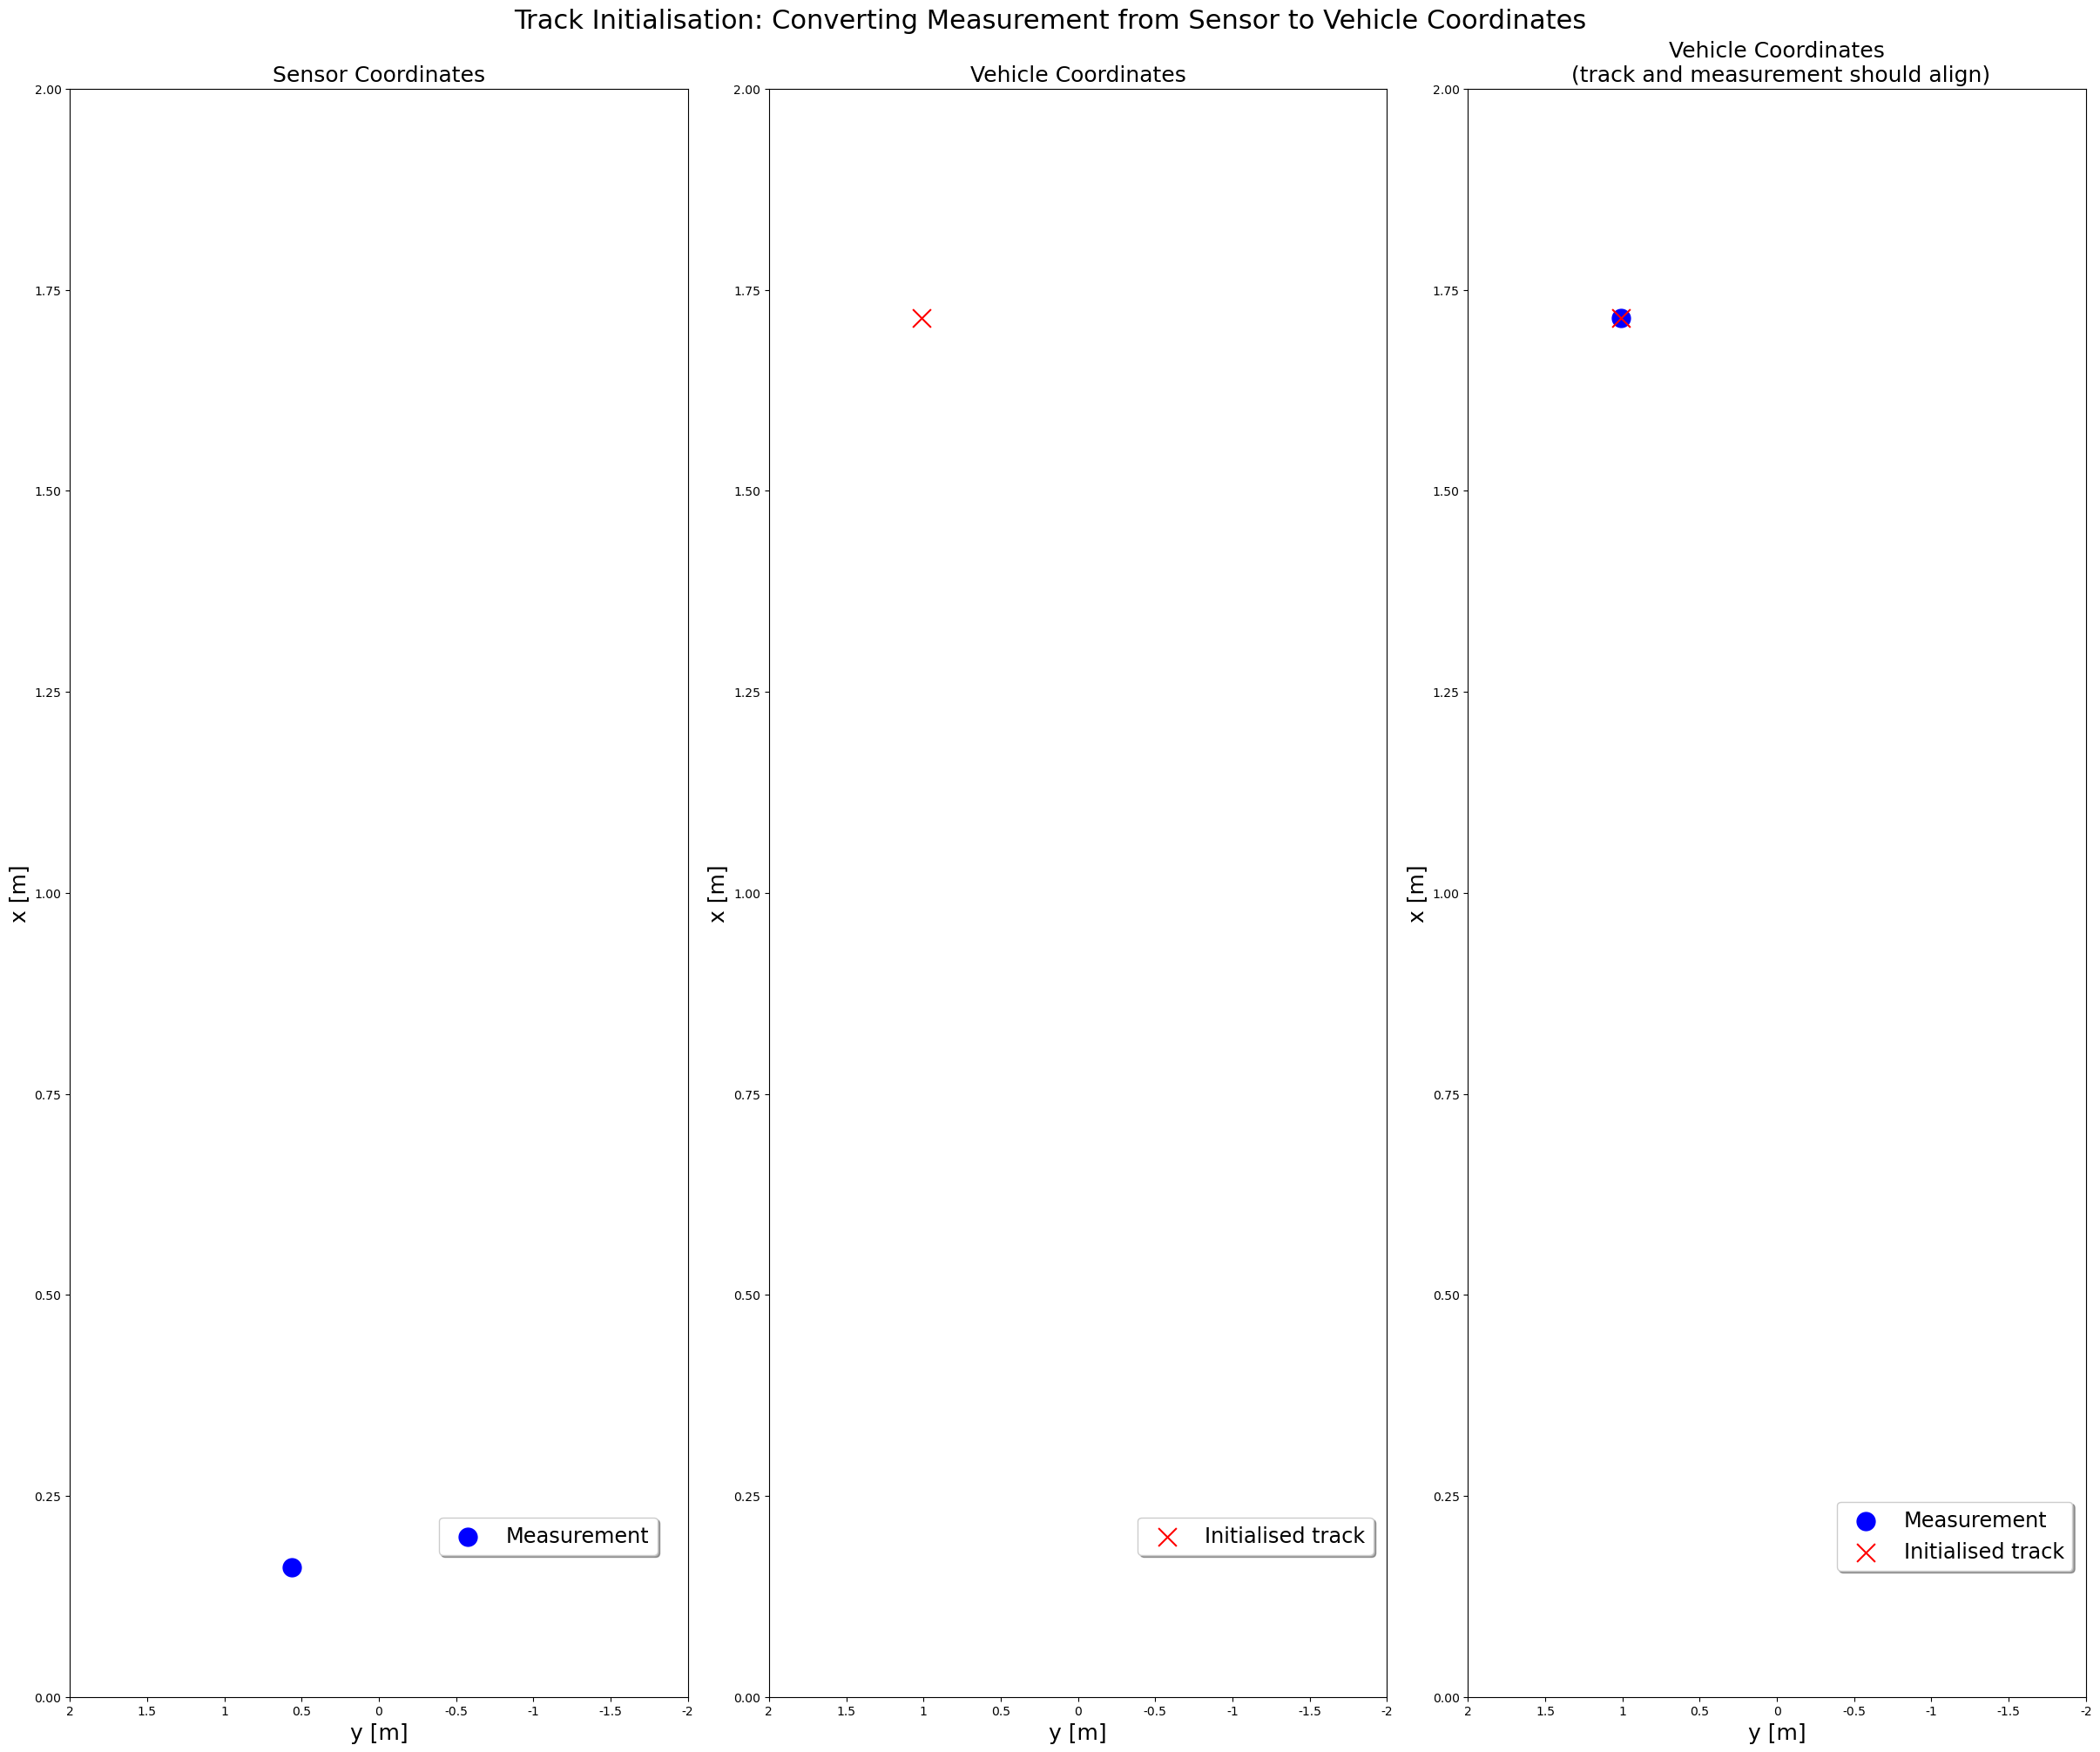

In [16]:
### Generate a new `Measurement` instance
meas = Measurement(gt, phi, t)
### Initialise a new track from this measurement
track = Track(meas, id=1)
### Visualise the new track with sensor measurement
visualize(track, meas)

Great! Shown on the right-most plot is the overlapping measurement and the initialised track. This means that we have correctly converted our measurement coordinates from sensor to vehicle frame.

#### 2.1.2. The `Camera` sensor class

Here we create a `Camera` sensor class to store the sensor-to-vehicle and vehicle-to-sensor transformation matrices needed to convert the measurement coordinates. In the `Camera` class we also define an `in_fov` function which returns `True` if the given measurement `x` lies within the region spanned by the sensor's field of view. This will allow us to later implement a heuristic function which assigns a measurement a detection probability. In other words, how likely it is that the measurement generated is visible by the sensor. The detection probability will be used in conjunction with other probabilistic measures to handle occluded objects appropriately.

In [17]:
### From J. Moran's `2_fov.py`
# Credit: https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/cb5718cb06bb052c3101859ee8ed609f4775172b/2-Sensor-Fusion/Exercises/2-4-Multi-Target-Tracking/exercises/2_fov.py

In [18]:
class Camera(object):
    '''The Camera sensor class.

    Implements the coordinate transformations between sensor and vehicle
    coordinate frames, as well as the field of view (FOV) sanity checking
    for tracking / sensor fusion tasks.

    :param fov: the opening angle (i.e., field of view) of the camera sensor.
    :param sens_to_veh: the coordinate transformation matrix from the
        sensor frame to the vehicle frame (i.e., the extrinsics matrix).
    :param veh_to_sen: the coordinate transformation matrix from the
        vehicle frame to the sensor frame.
    '''

    def __init__(self,
            phi: np.radians, t: np.ndarray
    ):
        """Initialises a Camera instance.

        :param phi: the angle between the vehicle frame and the sensor frame,
            i.e., the angle of rotation between the x-axes.
        :param t: the translation vector describing the offset along the x-axis
            of the sensor frame origin from the vehicle frame origin.
        """

        ### Defining the sensor attributes
        # The sensor field of view (i.e., the opening angle)
        self.fov = [-np.pi / 4, np.pi / 4]
        # Here we compute the rotation around the z-axis w.r.t. angle `phi`
        M_rot = np.array([
                    [np.cos(phi), -np.sin(phi), 0],
                    [np.sin(phi), np.cos(phi), 0],
                    [0, 0, 1]
        ])
        ### Defining the coordinate transformation matrices
        # Here we construct the sensor-to-vehicle transformation matrix
        self.sens_to_veh = np.array(np.identity(n=4))
        self.sens_to_veh[0:3, 0:3] = M_rot
        self.sens_to_veh[0:3, 3:] = t
        # Here we construct the vehicle-to-sensor transformation matrix
        self.veh_to_sens = np.linalg.inv(self.sens_to_veh)
    
    def in_fov(self,
            x: np.ndarray
    ) -> bool:
        """Checks if the given object `x` is within the sensor field of view.

        :param x: the object state vector to obtain the coordinates from,
            note that the position is defined w.r.t. the vehicle frame.
        :returns: boolean, whether or not the object at its position can be
            seen by the sensor, i.e., if the object is within the sensor's FOV.
        """

        ### Transform the track state position coordinates into sensor frame
        # Obtain the position coordinates of the object in sensor frame
        _p_sens = x[0:3]
        # Convert to homogeneous coordinates
        _p_sens = np.vstack([_p_sens, np.newaxis])
        _p_sens[3] = 1
        # Construct the vehicle-to-sensor transformation
        _p_veh = self.veh_to_sens @ _p_sens
        # Obtain the position coordinates of the object in sensor frame
        p_x, p_y, _ = _p_veh[0:3]
        ### Check if the object at tracked position can be seen by the sensor
        # Calculate the angle offset of the object w.r.t. the vehicle frame
        if p_x == 0:
            # Make sure that the divisor is not zero
            raise ZeroDivisionError
        alpha = math.atan(p_y / p_x)
        # Check if the angle offset is within the camera opening angle
        if np.abs(alpha) <= self.fov[1]:
            return True
        else:
            return False

##### Visualising the `Camera` sensor field of view

In [19]:
### From J. Moran's `2_fov.py`
# Credit: https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/cb5718cb06bb052c3101859ee8ed609f4775172b/2-Sensor-Fusion/Exercises/2-4-Multi-Target-Tracking/exercises/2_fov.py

In [20]:
def run():
    """Tests the camera visibility function and plots the results.

    A `Camera` instance is created with a set of attribute values specifying its
    translation vector and angle of rotation. Inside the `Camera` class is the
    definition of the sensor field of view used to check whether or not an object
    lies within the camera field of view. Here the object state is initialised
    with simulated track position and velocity values.
    """

    ### Defining the camera parameters
    # The translation vector
    t = np.array([[2],
                  [0],
                  [0]
    ])
    # The angle of rotation between vehicle and sensor frame
    phi = np.radians(45)
    ### Creating a new `Camera` instance
    cam = Camera(phi, t)
    ### Initialise the Matplotlib figure
    fig, ax = plt.subplots(1, 1,figsize=(24, 20),
                    constrained_layout=True
    )
    # Setting the figure title
    txt1 = 'Track Positions With Respect to Camera Field of View'
    fig.suptitle(txt1, fontsize=22)
    ### Running the programme loop over the simulated track detections
    for i in range(50):
        # Define the track state vector, i.e., position and velocity estimate
        # Note that the position is defined w.r.t. the vehicle frame
        x = np.array([
                [np.random.uniform(-5, 5)],     # Position along x-axis
                [np.random.uniform(-5, 5)],     # Position along y-axis
                [0],                            # Position along z-axis
                [0],                            # Velocity along x-axis
                [0],                            # Velocity along y-axis
                [0]                             # Velocity along z-axis
        ])
        ### Check if the position of tracked object `x` is visible by the camera
        result = cam.in_fov(x)
        ### Plot the results
        # Define the homogeneous coordinate system
        pos_veh = np.ones((4, 1))
        # Obtain the position estimate from the track state vector
        pos_veh[0:3] = x[0:3] 
        # Construct the vehicle-to-sensor coordinate transformation 
        pos_sens = cam.veh_to_sens @ pos_veh
        if result == True:
            ### If the position is within the camera field of view
            # Plot the track position with a marker of colour `col`
            col = 'green'
            ax.scatter(float(-pos_sens[1]), float(pos_sens[0]),
                            marker='o', s=225, color=col, label='Visible track'
            )
        else:
            ### If the position is not within the camera field of view
            # Plot the track position with a marker of colour `col`
            col = 'red'
            ax.scatter(float(-pos_sens[1]), float(pos_sens[0]),
                            marker='o', s=225, color=col, label='Invisible track'
            )
        ax.text(float(-pos_sens[1]), float(pos_sens[0]), str(result), clip_on=True)  
    ### Plot the field of view of the camera sensor
    ax.plot([0, -5], [0, 5], color='blue', label='Field of view') 
    ax.plot([0, 5], [0, 5], color='blue')
    # Maximise the figure window
    if matplotlib.rcParams['backend'] == 'wxagg':
        mng = plt.get_current_fig_manager()
        mng.frame.Maximize(True)
    ### Remove any repeated labels from the figure
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    ### Set the figure properties
    # Initialise the legend instance
    ax.legend(handle_list, label_list, loc='center left',
                        shadow=True, fontsize='xx-large', bbox_to_anchor=(0.85, 0.1)
    )
    # Set the axes labels
    ax.set_xlabel('y [m]', fontsize=18)
    ax.set_ylabel('x [m]', fontsize=18)
    # Set the x-axis and y-axis limits
    ax.set_xlim(-5, 5)
    ax.set_ylim(0, 5)
    ax.margins(0)
    # Correct the x-axis ticks so that the positive values are to the left
    ticks_x = ticker.FuncFormatter(
        lambda x, pos: '{0:g}'.format(-x) if x != 0 else '{0:g}'.format(x)
    )
    ax.xaxis.set_major_formatter(ticks_x)
    ### Show the resulting plot
    if matplotlib.rcParams['backend'] != 'agg':
        plt.show()

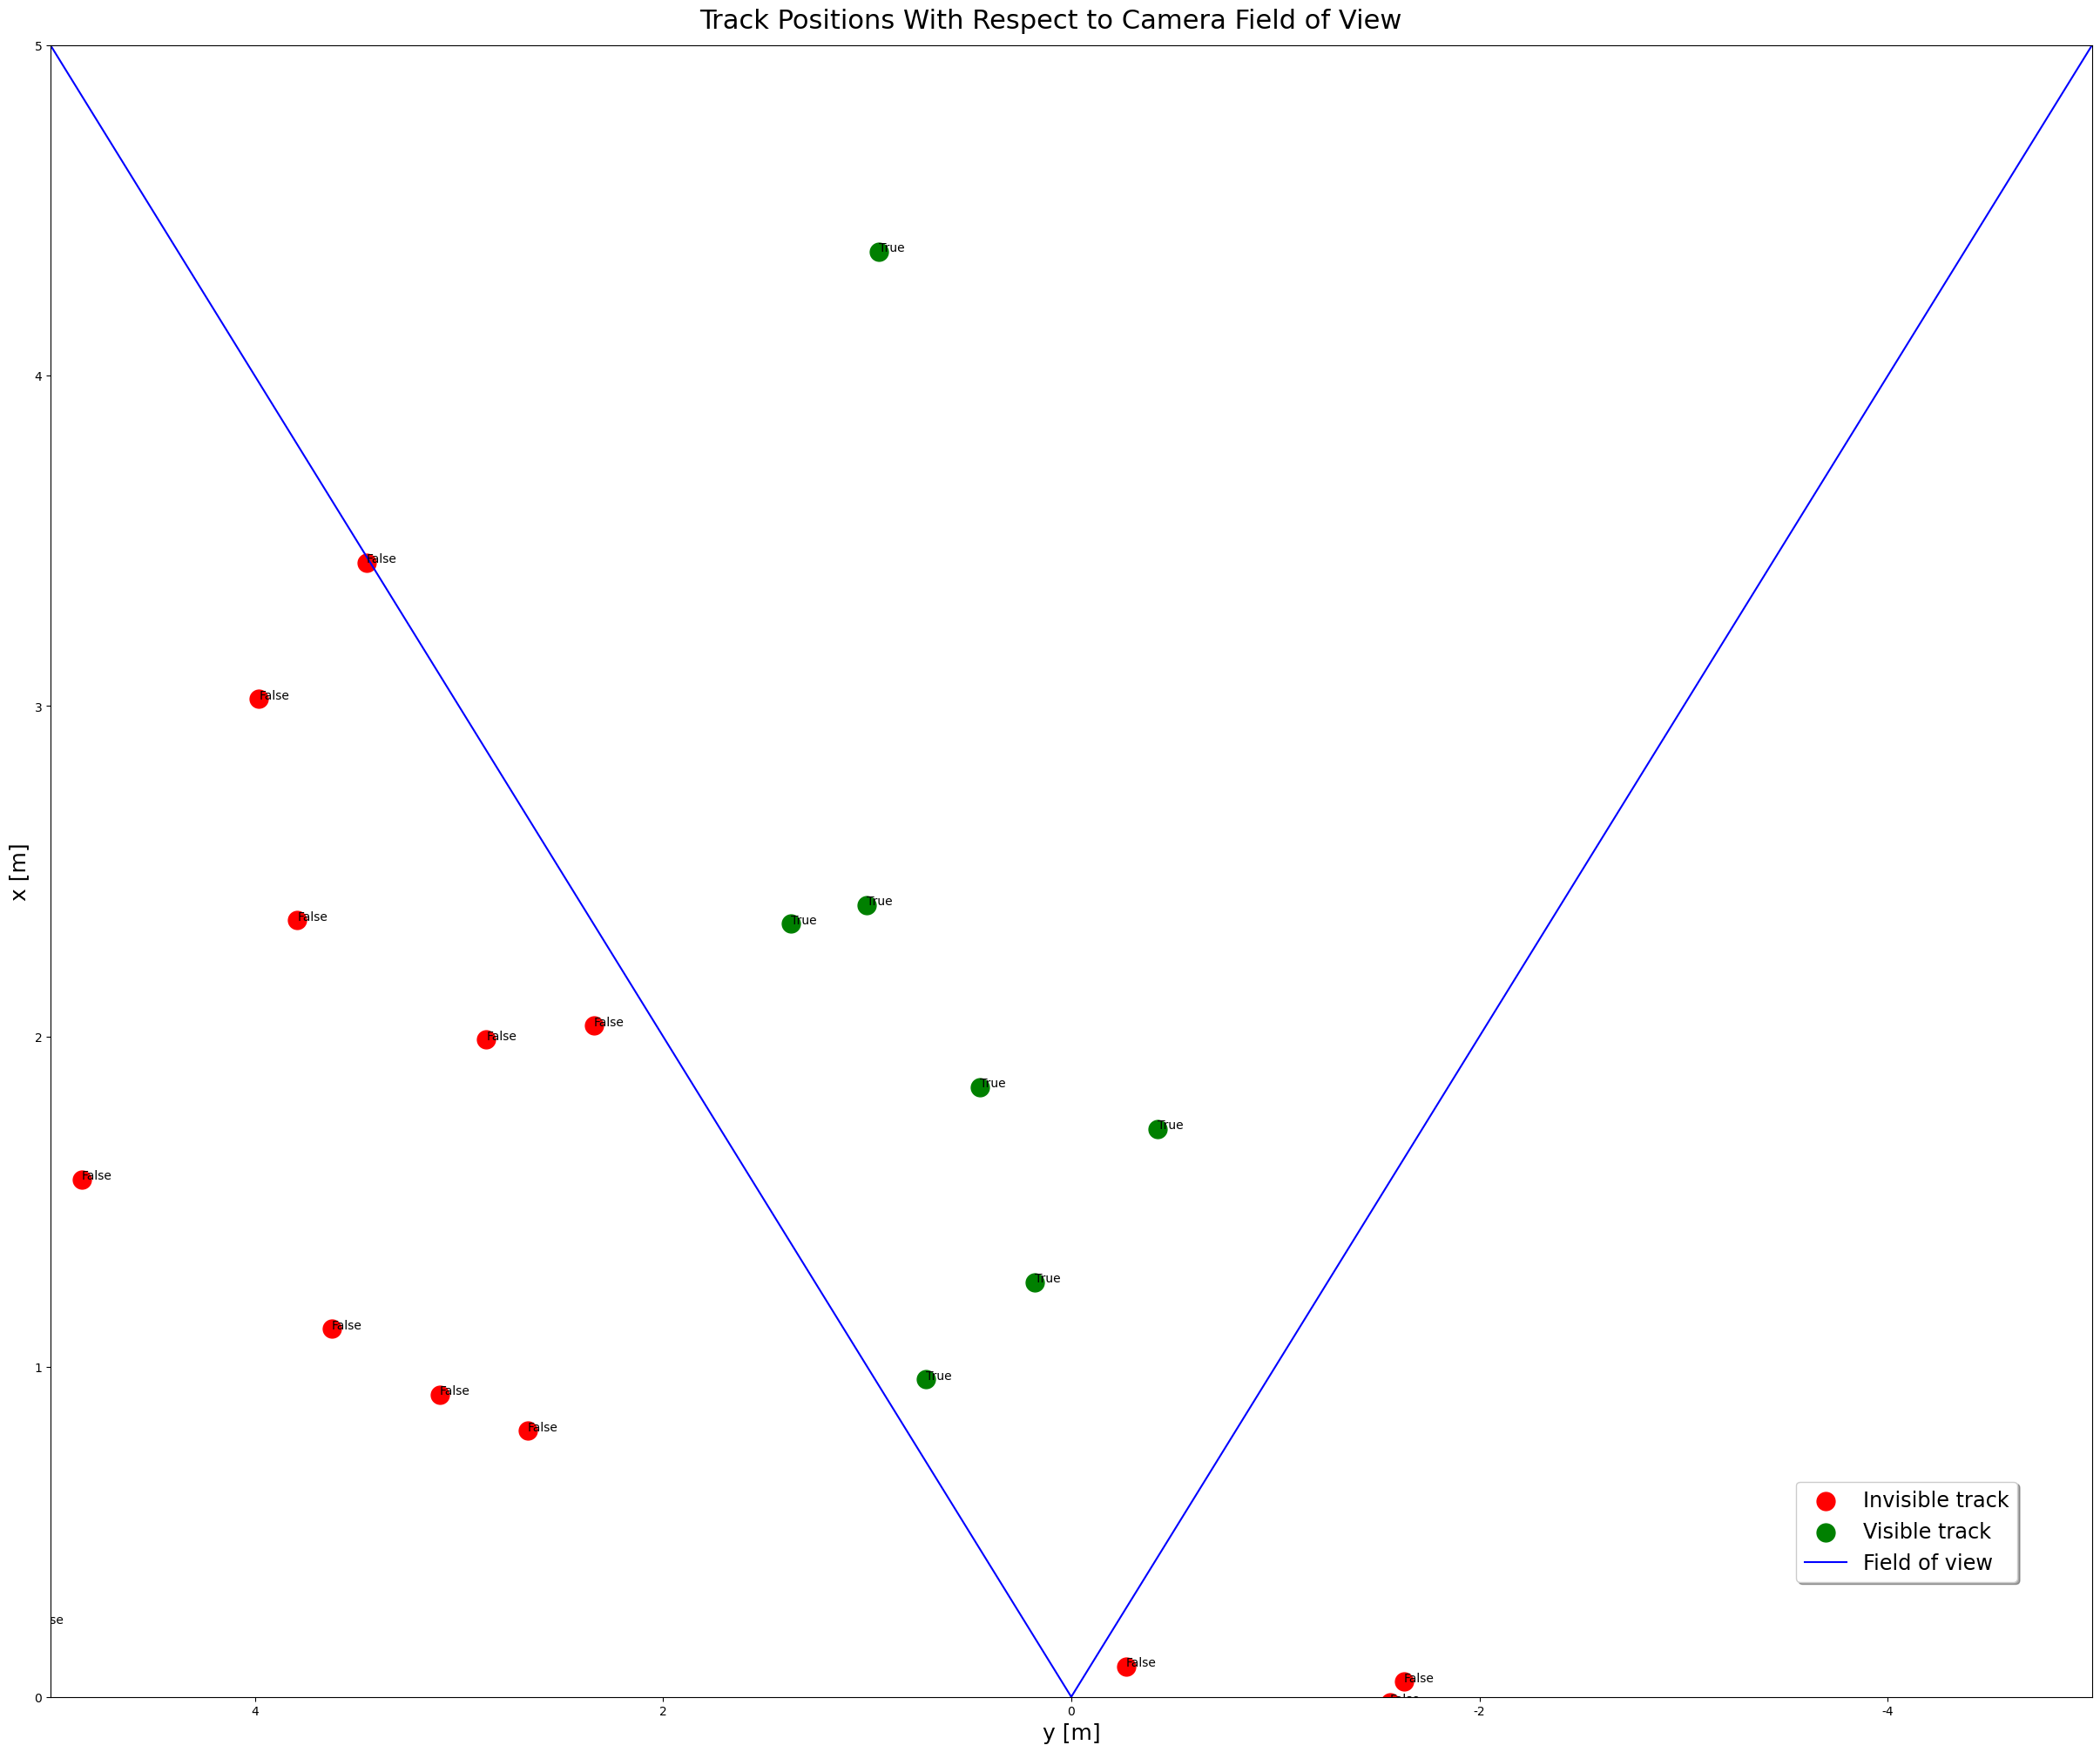

In [21]:
### Run the main loop
run()

Here we see the tracks whose position estimates correspond to locations inside the camera sensor's field of view. This information will be used to later implement a detection probability to better handle the tracking of occluded objects.

#### 2.1.3. The `Association` class

In this third part we implement the Single Nearest Neighbor (SNN) tracking algorithm to perform the data association task. The `Association` class defined below uses the `calc_mhd` function to compute the Mahalanobis distance between each track-measurement pair. Then, the `associate` function constructs an association matrix and assigns each entry to the Mahalanobis distance score of the corresponding track-measurement pair.

To evaluate the results of our association algorithm, we simulate three measurements and three tracks and run the association algorithm over the pairs. The resulting Matplotlib figure will contain (1) the tracks / measurements, (2) the corresponding Mahalanobis distance for between each pair and all others, and (3) the associations as determined by the shortest distance calculation.

In [22]:
### From J. Moran's `3_association_matrix.py`
# Credit: https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/cb5718cb06bb052c3101859ee8ed609f4775172b/2-Sensor-Fusion/Exercises/2-4-Multi-Target-Tracking/exercises/3_association_matrix.py

In [23]:
class Measurement(object):
    '''The Measurement class.

    :param id: the unique measurement id.
    :param z: the measurement vector containing the position estimate.
    :param R: the measurement error covariance matrix.
    '''

    def __init__(self,
            id: int, x: np.ndarray, y: np.ndarray
    ):
        """Initialises a new Measurement instance.

        :param id: the unique measurement id.
        :param x: the x-coordinate of the measured position.
        :param y: the y-coordinate of the measured position.
        """

        ### Initialise the new measurement
        # Set the unique measurement id
        self.id = id
        # Generate the measurement vector
        self.z = np.array([
                    [x + np.random.normal(0, 2)],
                    [y + np.random.normal(0, 2)]
        ])
        # Initialise the measurement error covariance matrix
        self.R = np.array([
                    [2, 0],
                    [0, 2]
        ])


class Track(object):
    '''The Track class.

    :param id: the unique track id.
    :param x: the state vector containing the position estimate.
    :param P: the estimation error covariance matrix.
    '''

    def __init__(self, 
            id: int
    ):
        """Initialises a new Track instance.

        :param id: the unique track id.
        """

        ### Initialise a new track
        # Set the unique track id
        self.id = id
        # Generate a new state vector
        self.x = np.array([
                    [np.random.uniform(2, 8)],
                    [np.random.uniform(-3, 3)],
                    [0],
                    [0]
        ])
        # Initialise the estimation error covariance matrix
        self.P = np.array([
                    [2, 0, 0, 0],
                    [0, 3, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]
        ])


class Association(object):
    '''The Association class.

    Implements the Single Nearest Neighbour (SNN) association based
    on the Mahalanobis distance metric.

    :param association_matrix: the data association matrix used to assign
        uncertain measurements to known tracks.
    '''

    def __init__(self):
        """Initialises a new Association instance with matrix."""

        # Instantiate the association matrix
        self.association_matrix = np.array([])
        
    def associate(self,
            track_list: List[Track], meas_list: List[Measurement]
    ):
        """Implements the association algorithm.

        :param track_list: the list of known tracks that have not been assigned
            to a measurement.
        :param meas_list: the list of uncertain measurements that have not been
            assigned to a track.
        """

        # The number of tracks left to assign
        N = len(track_list)
        # The number of measurements left to assign
        M = len(meas_list)
        # Initialise the association matrix values
        self.association_matrix = np.inf * np.ones((N, M))
        for x_i, track in enumerate(track_list):
            for z_j, measurement in enumerate(meas_list):
                # Compute the Mahalanobis distance
                dist = self.calc_mhd(track, measurement)
                # Update the entry in the matrix with the distance value
                self.association_matrix[x_i, z_j] = dist

    def calc_mhd(self,
            track: Track, meas: Measurement
    ) -> float:
        """Implements the Mahalanobis distance calculation.

        :param track: the Track instance with known estimation error covariance.
        :param meas: the Measurement instance with uncertain position estimate
            and its measurement error covariance.
        :returns: the Mahalanobis distance measure between the given track
            and the measurement objects.
        """
        
        ### Compute the measurement matrix for the LiDAR sensor
        # Here we form a projection from 4D state space to 2D LiDAR measurement space
        _H = np.array([
                    [1., 0., 0., 0.],
                    [0., 1., 0., 0.]
        ])
        ### Compute the residual and its covariance for the LiDAR Sensor
        # Here we compute the residual
        gamma = meas.z - _H @ track.x
        # Here we compute the covariance of the residual
        _S = np.matmul(_H @ track.P, _H.T) + meas.R
        ### Compute the Mahalanobis distance
        dist = np.matmul(gamma.T @ np.linalg.inv(_S), gamma)
        return float(dist)

##### Testing the association algorithm

In [24]:
### From J. Moran's `3_association_matrix.py`
# Credit: https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/cb5718cb06bb052c3101859ee8ed609f4775172b/2-Sensor-Fusion/Exercises/2-4-Multi-Target-Tracking/exercises/3_association_matrix.py

In [25]:
def run():
    """Tests the track / measurement association and visualises the results."""

    ### Initialise the association variables
    # Fix the seed s.t. random values are predictable
    np.random.seed(5)
    # Instantiate the data association instance
    association = Association()
    # Initialise the association lists
    track_list = []
    meas_list = []
    ### Create the Matplotlib figure instance
    # Initialise a new subplot
    fig, ax = plt.subplots(1, 1, figsize=(24, 20), constrained_layout=True)
    # Set the figure title
    txt1 = 'Track and Measurement Association: Mahalanobis Distance'
    fig.suptitle(txt1, fontsize=22)
    ### Simulate measurements and run the data association task
    for i in range(3):
        # Create a new track instance
        track = Track(i + 1)
        # Append the new track to the known tracks list
        track_list.append(track)
        # Plot the track
        ax.scatter(float(-track.x[1]), float(track.x[0]),
                        marker='x', s=225, color='red', label='Track'
        )
        # Set the track label
        ax.text(float(-track.x[1] + 0.05), float(track.x[0] + 0.05),
                        str(track.id), fontsize=18, color='red'
        )
        # Create a new measurement instance
        meas = Measurement(i + 1, float(track.x[0]), float(track.x[1]))
        # Append the new measurement to the uncertain measurements list
        meas_list.append(meas)
        # Plot the measurement
        ax.scatter(float(-meas.z[1]), float(meas.z[0]),
                        marker='o', s=225, color='green', label='Measurement'
        )
        # Set the measurement label
        ax.text(float(-meas.z[1] + 0.05), float(meas.z[0] + 0.05),
                        str(meas.id), fontsize=18, color='green'
        )
    ### Calculate the association matrix
    association.associate(track_list, meas_list)
    print('Association matrix:', association.association_matrix)
    ### Visualise the Mahalanobis distances
    for track in track_list:
        for meas in meas_list:
            # Get the track-measurement distance
            dist = association.association_matrix[track.id - 1, meas.id - 1]
            if dist < np.inf:
                # Plot the distance
                ax.plot([float(-track.x[1]), float(-meas.z[1])],
                        [float(track.x[0]), float(meas.z[0])],
                        color='gray', label='Distance'
                )
                # Set the distance label
                str_dist = "{:.2f}".format(dist)
                ax.text(
                    float((-track.x[1] - meas.z[1]) / 2), 
                    float((track.x[0] + meas.z[0]) / 2), 
                    str_dist, fontsize=16, clip_on=True
                )
    # Maximise the figure window
    if matplotlib.rcParams['backend'] == 'wxagg':
        mng = plt.get_current_fig_manager()
        mng.frame.Maximize(True)
    ### Remove any repeated labels from the figure
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    ### Set the figure properties
    # Initialise the legend
    ax.legend(handle_list, label_list, loc='center left',
                    shadow=True, fontsize='xx-large', bbox_to_anchor=(.88, .05)
    )
    # Set the axes labels
    ax.set_xlabel('y [m]', fontsize=18)
    ax.set_ylabel('x [m]', fontsize=18)
    # Set the axes limits
    ax.set_xlim(-5, 5)
    ax.set_ylim(0, 10)
    # Correct the x-axis ticks so that the positive values are to the left
    ticks_x = ticker.FuncFormatter(
        lambda x, pos: '{0:g}'.format(-x) if x != 0 else '{0:g}'.format(x)
    )
    ax.xaxis.set_major_formatter(ticks_x)
    ### Show the resulting plot
    if matplotlib.rcParams['backend'] != 'agg':
        plt.show()

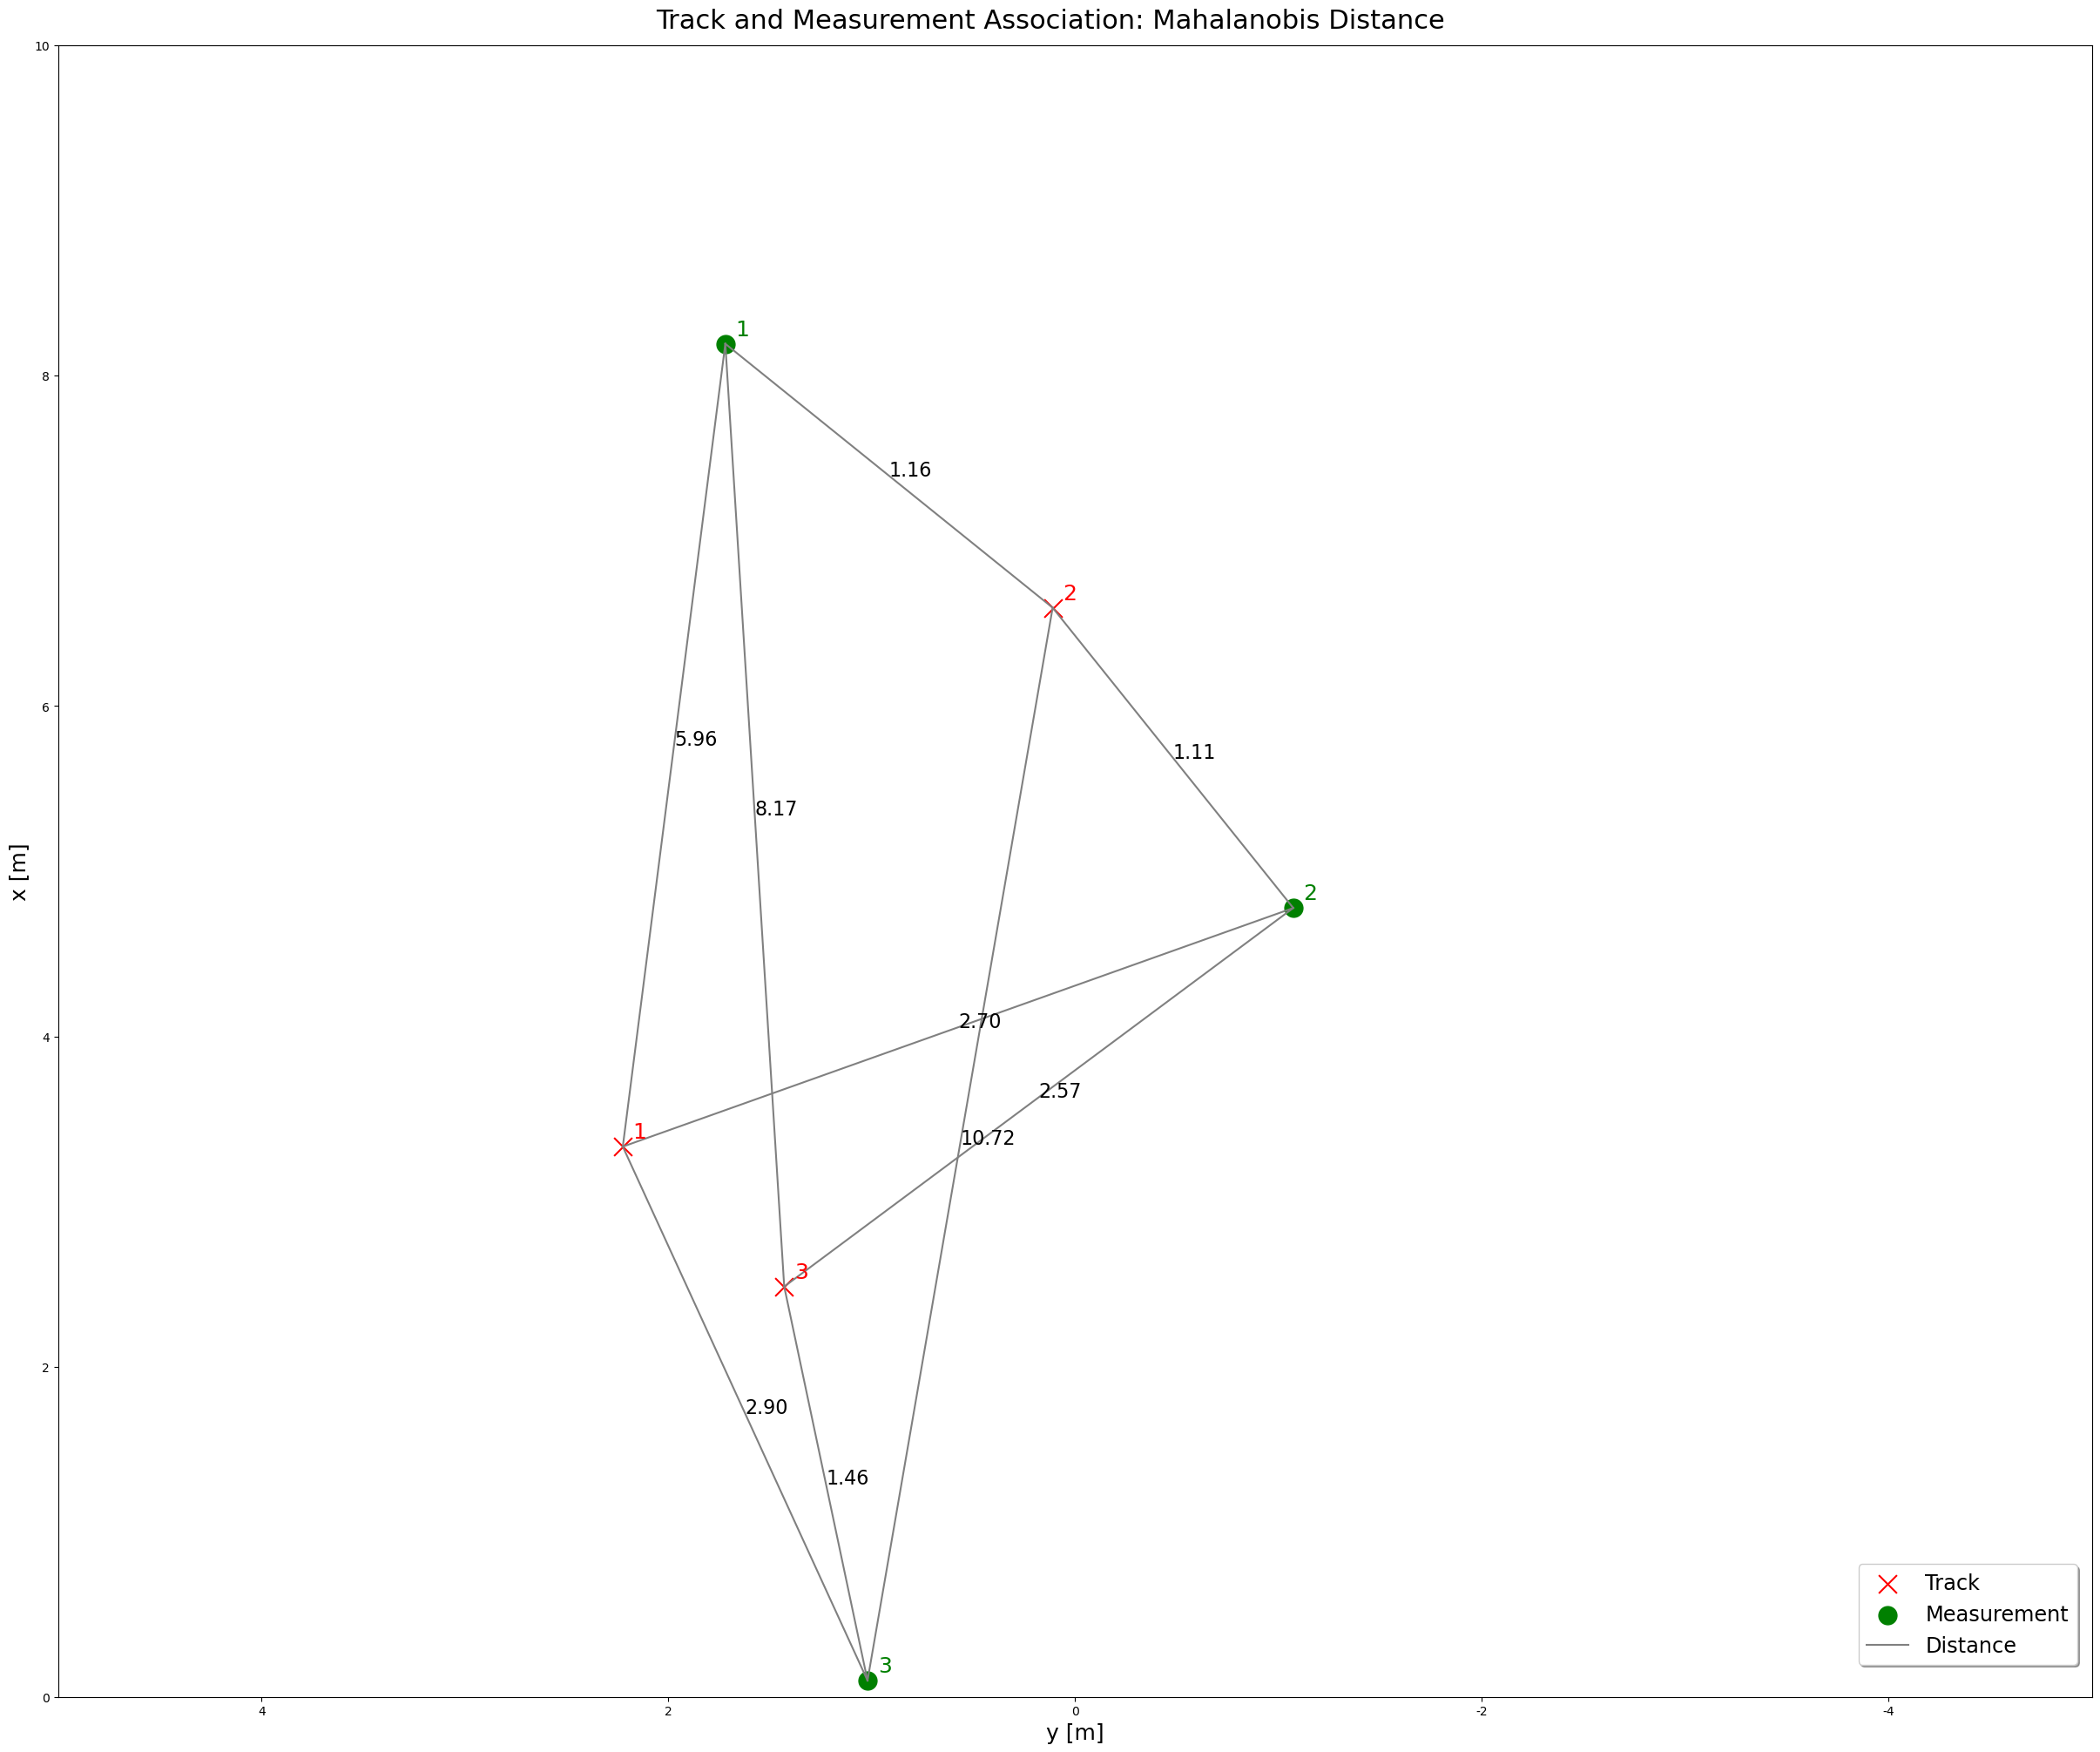

In [26]:
### Run the association programme
run()

In the plot above we see the corresponding Mahalanobis distances computed for each state-measurement pair. In the next task, we will use these distances to perform a closest distance association with a gating function to speed up the performance of this computationally-intensive task.

#### 2.1.4. The validation gating algorithm

In this last section we add a validation gating scheme to our association algorithm. This results in a slight performance improvement by reducing the number of unlikely assocations that are explored. By making core assumptions about the distribution of the Mahalanobis calculation and the corresponding position estimation error covariance, we can exploit the inverse cumulative distribution function of a [Chi-square distribution]() $\chi^{2}$ and use this result to form a threshold restricting the likelihood of "false alarm" occurrences — the number of false positive measurements with a given position lying within the covariance, i.e., region of uncertainty surrounding the position estimate. The gating function therefore guarantees with confidence of $\alpha = 0.95$ that the explored measurements for an association are within the boundary formed by the hyper-ellipse.

To evaluate the results of our gating algorithm, we visualise the associations and related data as before — but we also print the explored associations at each iteration to demonstrate the performance advantages compared to the number of iterations taken before.

In [27]:
### From J. Moran's `4_gating.py`
# Credit: https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/cb5718cb06bb052c3101859ee8ed609f4775172b/2-Sensor-Fusion/Exercises/2-4-Multi-Target-Tracking/exercises/4_gating.py

In [28]:
class Measurement(object):
    '''The Measurement class.

    :param id: the unique measurement id.
    :param z: the measurement vector containing the position estimate.
    :param R: the measurement error covariance matrix.
    '''

    def __init__(self,
            id: int, x: np.ndarray, y: np.ndarray
    ):
        """Initialises a new Measurement instance.

        :param id: the unique measurement id.
        :param x: the x-coordinate of the measured position.
        :param y: the y-coordinate of the measured position.
        """

        ### Initialise the new measurement
        # Set the unique measurement id
        self.id = id
        # Generate the measurement vector
        self.z = np.array([
                    [x + np.random.normal(0, 2)],
                    [y + np.random.normal(0, 2)]
        ])
        # Initialise the measurement error covariance matrix
        self.R = np.array([
                    [2, 0],
                    [0, 2]
        ])


class Track(object):
    '''The Track class.

    :param id: the unique track id.
    :param x: the state vector containing the position estimate.
    :param P: the estimation error covariance matrix.
    '''

    def __init__(self, 
            id: int
    ):
        """Initialises a new Track instance.

        :param id: the unique track id.
        """

        ### Initialise a new track
        # Set the unique track id
        self.id = id
        # Generate a new state vector
        self.x = np.array([
                    [np.random.uniform(2, 8)],
                    [np.random.uniform(-3, 3)],
                    [0],
                    [0]
        ])
        # Initialise the estimation error covariance matrix
        self.P = np.array([
                    [2, 0, 0, 0],
                    [0, 3, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]
        ])


class Association(object):
    '''The Association class.

    Implements the Single Nearest Neighbour (SNN) association and
    1-D validation gating based on the Mahalanobis distance metric.

    The SNN is a non-Bayesian approach assuming that each track generates
    at most one measurement and that each measurement originates from
    at most one track.

    The validation gate is a region of acceptance such that a percentage
    $100 * (1 - \alpha)$ of true measurements are rejected.

    :param association_matrix: the data association matrix used to assign
        uncertain measurements to known tracks.
    :param unassigned_tracks: the list of known tracks that have not been
        assigned to a measurement.
    :param unassigned_meas: the list of uncertain measurements that have not
        been assigned to a track.
    '''

    def __init__(self):
        """Initialises the Association instance and its attributes."""

        self.association_matrix = np.array([])
        self.unassigned_tracks = []
        self.unassigned_meas = []
        
    def associate(self, 
            track_list: List[Track], meas_list: List[Measurement]
    ):
        """Implements the assocation algorithm.

        :param track_list: the list of known tracks that have not been assigned
            to a measurement.
        :param meas_list: the list of uncertain measurements that have not been
            assigned to a track.
        """

        # The number of tracks left to assign
        N = len(track_list)
        # The number of measurements left to assign
        M = len(meas_list)
        # The list of indices of the unassigned tracks
        self.unassigned_tracks = list(range(N))
        # The list of indices of the unassigned measurements
        self.unassigned_meas = list(range(M))
        # Initialise the association matrix values
        self.association_matrix = np.inf * np.ones((N, M))
        for x_i, track in enumerate(track_list):
            for z_j, measurement in enumerate(meas_list):
                # Compute the Mahalanobis distance
                dist = self.calc_mhd(track, measurement)
                # Update the entry in the matrix with the distance value
                self.association_matrix[x_i, z_j] = dist
        
    def calc_mhd(self,
            track: Track, meas: Measurement
    ) -> float:
        """Implements the Mahalanobis distance calculation.

        :param track: the Track instance with known estimation error covariance.
        :param meas: the Measurement instance with uncertain position estimate
            and its measurement error covariance.
        :returns: the Mahalanobis distance measure between the given track
            and the measurement objects.
        """
        
        ### Compute the measurement matrix for the LiDAR sensor
        # Here we form a projection from 4D state space to 2D LiDAR measurement space
        _H = np.array([
                [1., 0., 0., 0.],
                [0., 1., 0., 0.]
        ])
        ### Compute the residual and its covariance for the LiDAR Sensor
        # Here we compute the residual
        gamma = meas.z - _H @ track.x
        # Here we compute the covariance of the residual
        _S = np.matmul(_H @ track.P, _H.T) + meas.R
        ### Compute the Mahalanobis distance
        dist = np.matmul(gamma.T @ np.linalg.inv(_S), gamma)
        return dist
    
    def gating(self,
            dist_mh: float, p_thresh: float=0.95, df_z: int=2
    ) -> bool:
        """Checks if the measurement is inside the gating region.

        The 1-D validation gate assumes a Gaussian measurement model
        with residual covariance $\mathrm{S}$. We define the area of the
        validation gate to be a hyper-ellipsoid which follows a Chi-square
        distribution, assuming that the Mahalanobis distance is a sum of
        squared standard normally-distributed random variables.

        The probability of a measurement `z` being inside the gating area is
        given w.r.t. a gating threshold $\gamma$ which can be obtained from
        the inverse Chi-square cumulative distribution for a significance level
        $\alpha$.

        :param dist_mh: the Mahalanbois distance.
        :param p_thresh: optional, the probability threshold, i.e., percentage
            of true measurements assumed to be within the gating area.
        :param df_z: optional, the degrees of freedom (DoF) of the measurement
            space of vector $z$.
        :returns: boolean, True if the measurement lies within the gate area.
        """ 

        ### Compute the inverse of the Chi-square cumulative distribution (cdf)
        # Using the percent point function (i.e., inverse of cdf)
        ppf = chi2.ppf(p=p_thresh, df=df_z)
        ### Check the Mahalanobis distance measure against the limit
        if dist_mh < ppf:
            return True
        else:
            return False
        
    def get_closest_track_and_meas(self
    ) -> Tuple[int, int]:
        """Return the indices of the closest track and measurement.

        Finds the closest pair and deletes their entries in the association matrix
        along with the corresponding ids in the `unassigned_tracks` and
        `unassigned_meas` lists.
        
        :returns: tuple, the closest unassociated track and measurement objects.
        """

        ### Find the closest track and measurement
        # Return NaN if no valid track / measurement pairs exist
        if np.min(self.association_matrix) == np.inf:
            return np.nan, np.nan
        # Get the indices of the entry with the lowest score
        idx_track, idx_measurement = np.unravel_index(
                indices=np.argmin(self.association_matrix, axis=None),
                shape=self.association_matrix.shape
        )
        ### Get the closest track and measurement objects
        track_closest = self.unassigned_tracks[idx_track]
        measurement_closest = self.unassigned_meas[idx_measurement]
        ### Remove the track and measurement objects from the lists
        self.unassigned_tracks.remove(track_closest)
        self.unassigned_meas.remove(measurement_closest)
        ### Remove the track-measurement pair from the association matrix
        _A = np.delete(self.association_matrix, idx_track, axis=0)
        self.association_matrix = np.delete(_A, idx_measurement, axis=1)
        return track_closest, measurement_closest

###### Testing the validation gating algorithm

In [29]:
### From J. Moran's `4_gating.py`
# Credit: https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/cb5718cb06bb052c3101859ee8ed609f4775172b/2-Sensor-Fusion/Exercises/2-4-Multi-Target-Tracking/exercises/4_gating.py

In [30]:
def run():
    """Tests the track / measurement association and visualises the results."""

    ### Initialise the association variables
    # Fix the seed s.t. random values are predictable
    np.random.seed(5)
    # Instantiate the data association instance
    association = Association()
    # Initialise the association lists
    track_list = []
    meas_list = []
    ### Create the Matplotlib figure instance
    # Initialise a new subplot
    fig, ax = plt.subplots(1, 1, figsize=(24, 20),
                    constrained_layout=True
    )
    # Set the figure title
    txt1 = 'Track and Measurement Association: Mahalanobis Distance'
    txt1 += ' with Validation Gating'
    fig.suptitle(txt1, fontsize=22)
    ### Simulate measurements and run the data association task
    # Number of simulated measurements / tracks to produce
    n_sim = 3
    for i in range(n_sim):
        # Create a new track instance
        track = Track(i + 1)
        # Append the new track to the known tracks list
        track_list.append(track)
        # Plot the track
        ax.scatter(float(-track.x[1]), float(track.x[0]),
                        marker='x', s=225, color='red', label='Track'
        )
        # Set the track label
        ax.text(float(-track.x[1]) + 0.05, float(track.x[0]) + 0.05,
                        str(track.id), fontsize=16, color='red'
        )
        # Create a new measurement instance
        meas = Measurement(i + 1, float(track.x[0]), float(track.x[1]))
        # Append the new measurement to the uncertain measurements list
        meas_list.append(meas)
        # Plot the measurement
        ax.scatter(float(-meas.z[1]), float(meas.z[0]),
                        marker='o', s=225, color='green', label='Measurement'
        )
        # Set the measurement label
        ax.text(float(-meas.z[1]) + 0.05, float(meas.z[0]) + 0.05,
                        str(meas.id), fontsize=18, color='green'
        )
    ### Calculate the association matrix with validation gating
    association.associate(track_list, meas_list)
    print('Association matrix:', association.association_matrix)
    print('unassigned_tracks list:', association.unassigned_tracks)
    print('unassigned_meas list:', association.unassigned_meas)     
    ### Visualise the Mahalanobis distances
    for track in track_list:
        for meas in meas_list:
            dist = association.association_matrix[track.id - 1, meas.id - 1]
            if dist < np.inf:
                # Plot the distance
                ax.plot(
                    [float(-track.x[1]), float(-meas.z[1])],
                    [float(track.x[0]), float(meas.z[0])],
                    color='gray', label='Distance'
                )
                # Set the distance label
                str_dist = "{:.2f}".format(dist)
                ax.text(
                    float((-track.x[1] - meas.z[1]) / 2),
                    float((track.x[0] + meas.z[0]) / 2),
                    str_dist, fontsize=16
                )
    ### Update the associated tracks with the measurements
    matrix_orig = association.association_matrix
    while (
        association.association_matrix.shape[0] > 0
        and association.association_matrix.shape[1] > 0
    ):
        ### Get next closest track and measurement
        ind_track, ind_meas = association.get_closest_track_and_meas()
        if np.isnan(ind_track):
            print('---no more associations---')
            break
        ### Fetch the track, measurement and Mahalnobis distance
        track = track_list[ind_track]
        meas = meas_list[ind_meas]
        dist = matrix_orig[ind_track, ind_meas]
        ### Plot the track and measurement association
        ax.plot(
            [float(-track.x[1]), float(-meas.z[1])],
            [float(track.x[0]), float(meas.z[0])],
            color='blue',
            label='Association',
            linewidth=3
        )
        # Set the distance label
        str_dist = "{:.2f}".format(dist)
        ax.text(
            float((-track.x[1] - meas.z[1]) + 0.05 / 2),
            float((track.x[0] + meas.z[0]) + 0.05 / 2),
            str_dist, fontsize=14, clip_on=True
        )
        f1 = f"Found association between track {ind_track + 1} "
        f1 += f"and measurement {ind_meas + 1} " 
        f1 += f"with Mahalanobis distance {str_dist}"
        print(f1)
        print('New association matrix:', association.association_matrix)
        print('New `unassigned_tracks`list:', association.unassigned_tracks)
        print('New `unassigned_meas` list:', association.unassigned_meas)
    # Maximise the figure window
    if matplotlib.rcParams['backend'] == 'wxagg':
        mng = plt.get_current_fig_manager()
        mng.frame.Maximize(True)
    ### Remove any repeated labels from the figure
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    ### Set the figure properties
    # Initialise the legend
    ax.legend(handle_list, label_list, loc='center left',
                    shadow=True, fontsize='xx-large', bbox_to_anchor=(.87, .05)
    )
    # Set the axes labels
    ax.set_xlabel('y [m]', fontsize=18)
    ax.set_ylabel('x [m]', fontsize=18)
    # Set the axes limits
    ax.set_xlim(-5, 5)
    ax.set_ylim(0, 10)
    # Correct the x-axis ticks so that the positive values are to the left
    ticks_x = ticker.FuncFormatter(
        lambda x, pos: '{0:g}'.format(-x) if x != 0 else '{0:g}'.format(x)
    )
    ax.xaxis.set_major_formatter(ticks_x)
    ### Show the resulting plot
    if matplotlib.rcParams['backend'] != 'agg':
        plt.show()

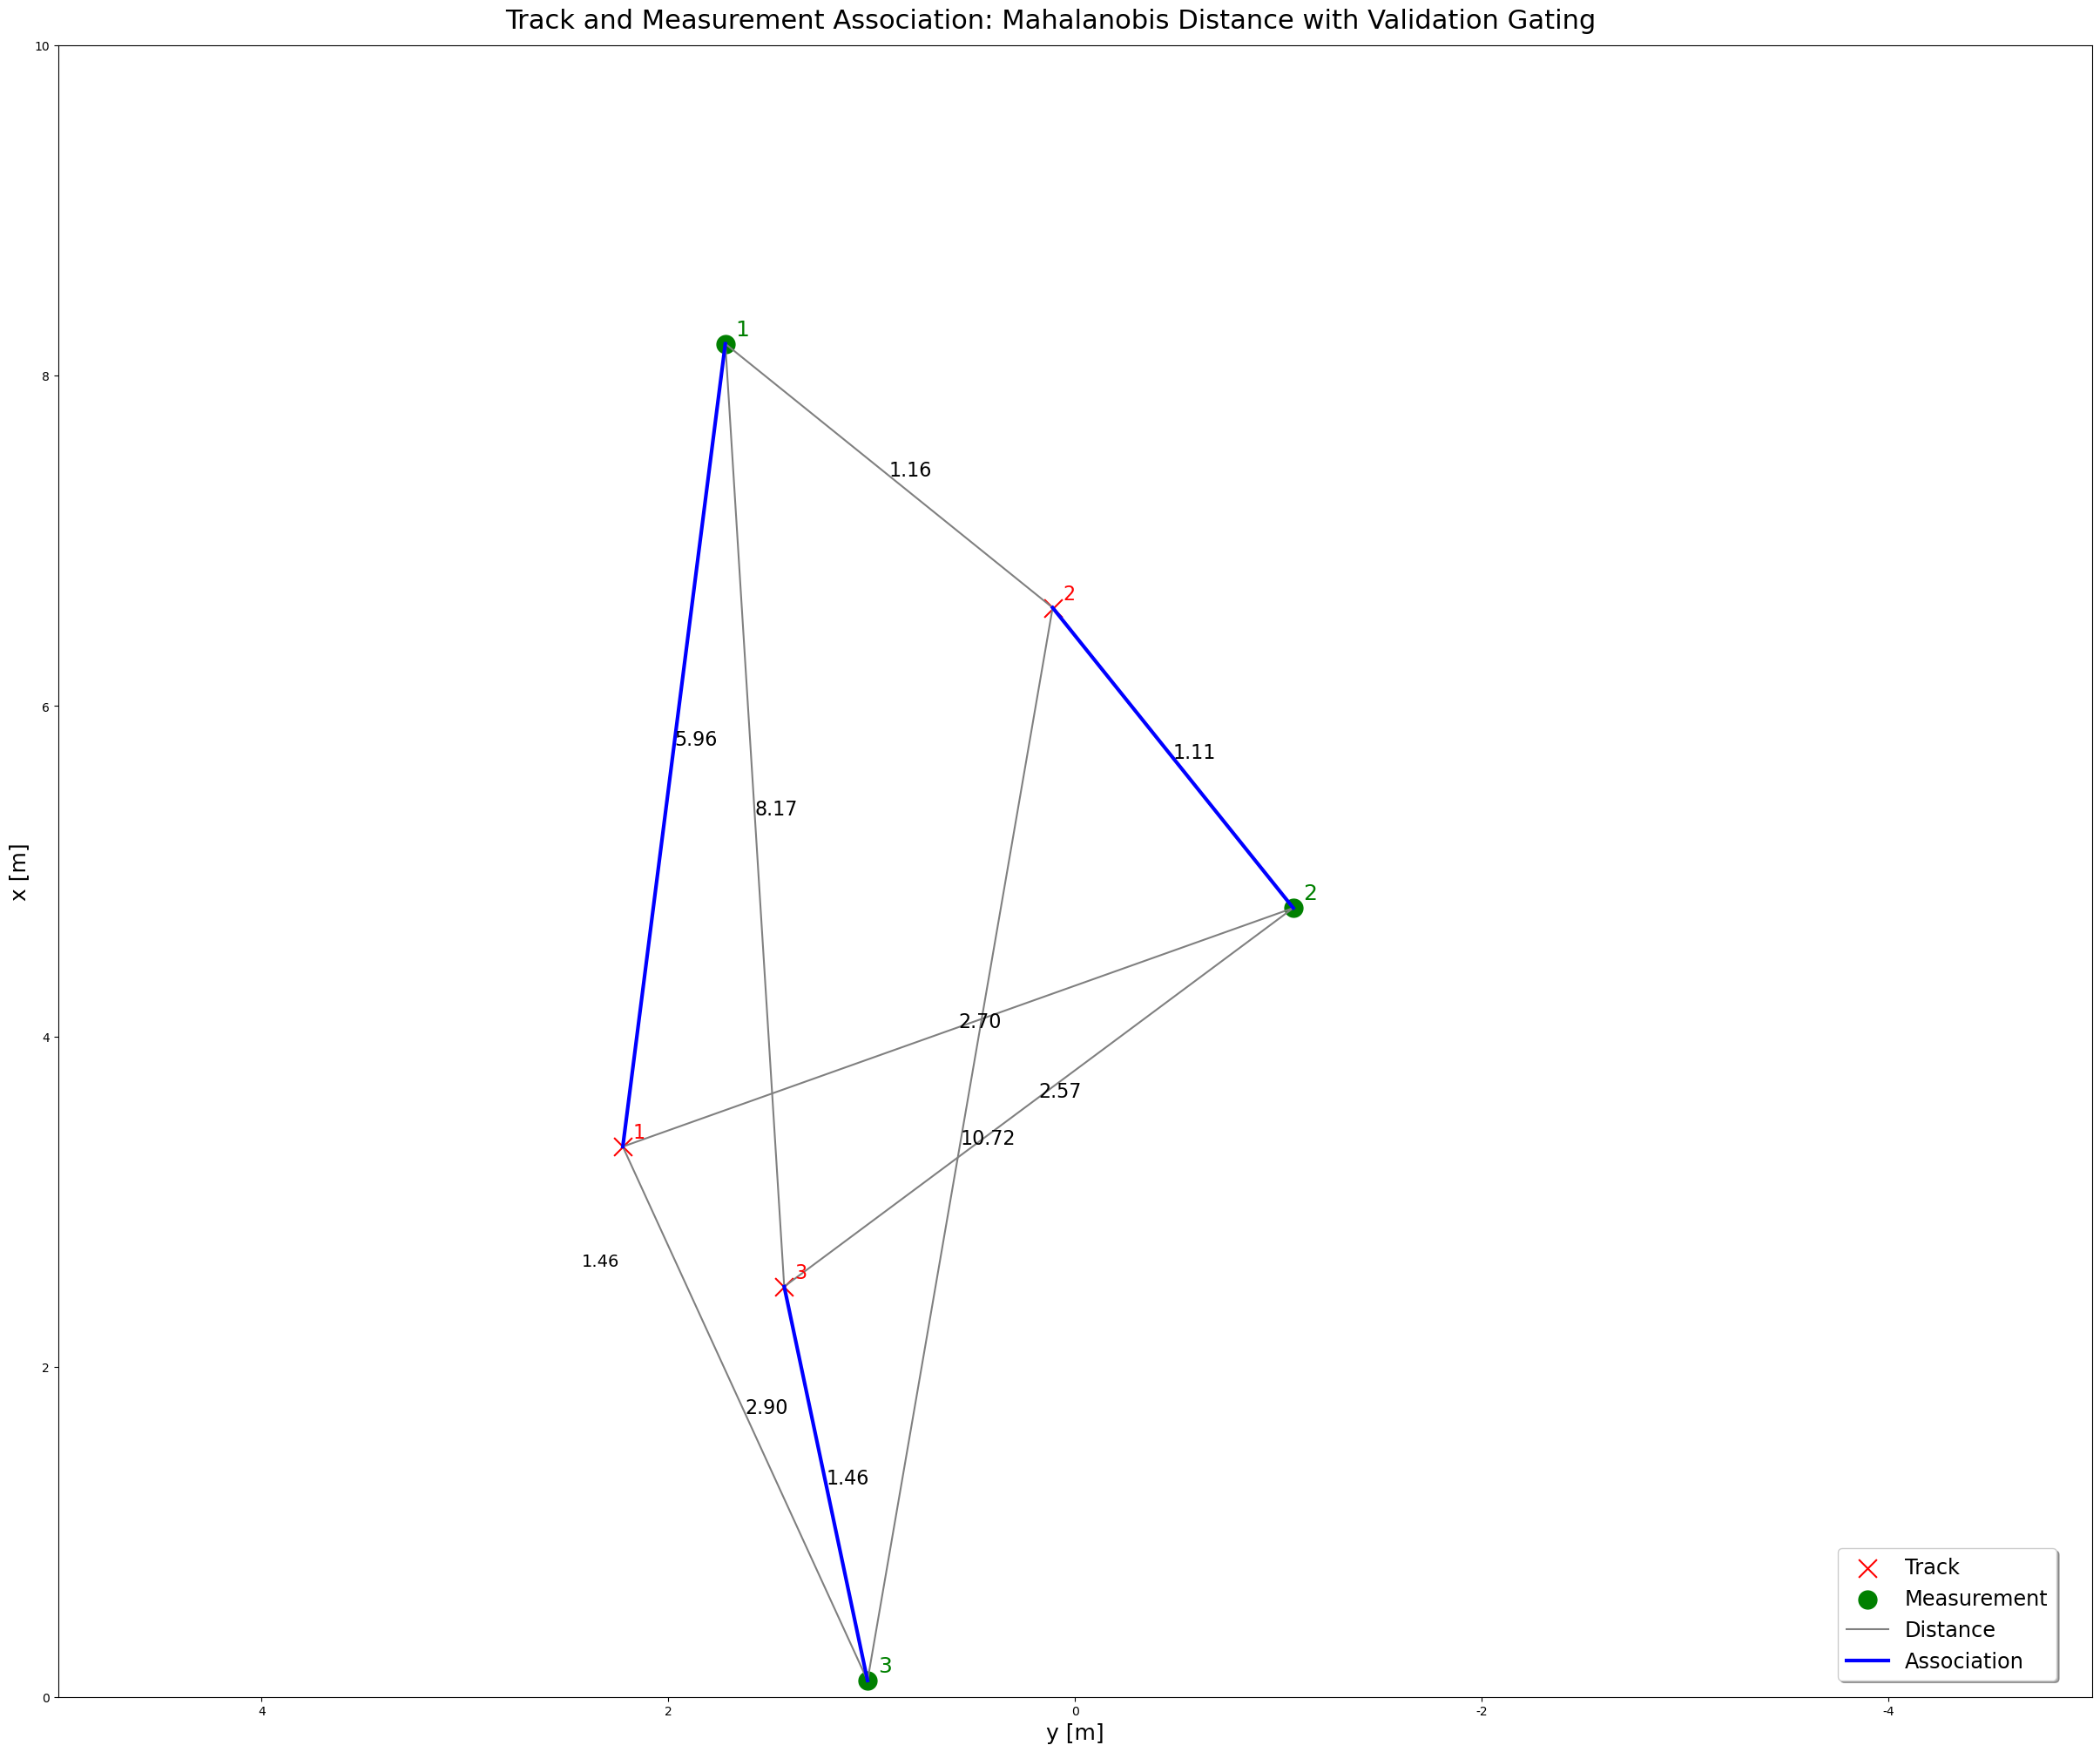

In [31]:
### Run the association with validation gating programme
run()

Fantastic — in this last plot we observe the shortest distance associations (shown in blue) together with the corresponding Mahalanobis distance scores. Great job following along!

## 3. Closing Remarks

Congratulations! If you've followed the code up to this point, you have everything you need to get started on your very own implementation of a multi-target tracking programme for use with both camera and LiDAR measurement data. You are well on your way to implementing a sensor fusion-based 3D object detection and tracking pipeline.

Good luck!

##### Alternatives
* Implement the Probabilistic Data Association algorithm or one of its variants (e.g., Joint Probabilistic Data Association, Joint Integrated Probabilistic Data Association);
* Extend the detection probability function to a more robust occlusion reasoning algorithm, e.g., 3D layout estimation, scene flow, semantic understanding, or some combination of all these techniques [1].

##### Extensions of task
* Implement a tracking evaluation function, e.g., [Root Mean Square Error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (RMSE);
* Extend the Single Nearest Neighbour (SNN) algorithm to Global Nearest Neighbor (GNN).

## 4. Future Work

- ⬜️ Evaluate the tracking results with an evaluation function, e.g., Root Mean Square Error;
- ⬜️ Implement the data association module alongside the 3D object detection pipeline for multi-target tracking with sensor fusion.

## Credits

This assignment was prepared by Dr. Andreas Haja and Dr. Antje Muntzinger et al., 2021 (link [here](https://github.com/udacity/nd013-c2-fusion-starter)).


References
* [1] Geiger, A. et al. 3D Traffic Scene Understanding from Movable Platforms. IEEE Transactions on Pattern Analysis and Machine Intelligence. 36(5):1012-1025. 2013. [doi:10.1109/TPAMI.2013.185](https://doi.org/10.1109/tpami.2013.185).

Helpful resources:
* [Robotics 2: Data Association Lecture Slides  by G. Grisetti, C. Stachniss et al. | Albert-Ludwigs-Universtität Freiburg](http://web.mit.edu/kirtley/kirtley/binlustuff/literature/control/Kalman%20filter.pdf);
* [ND0013 C2 L6 Lectures by Dr. Antje Muntzinger | YouTube](https://youtube.com/playlist?list=PL6nu8g-5OMNiT23So1PBXuL8B8HmBPpEJ).